# Building a Model to Predict Summary Scores

## First we need to prepare the data

### Load packages

In [1]:
%%capture
from pathlib import Path
import pandas as pd
import numpy as np
!pip install SentencePiece
!pip install "ray[tune]"
!pip install wandb

### Load paths

In [2]:
DATA = Path.cwd().parent / 'data'
SUMM_FOLDER = DATA / 'summaries_finetune'
TEXT_FILES = SUMM_FOLDER / 'text_files_copy'
SOURCE_TEXTS = SUMM_FOLDER / 'source_texts'

### Make a dataframe with the filename and the path name
Not all of the files are in the same directory, so we are going to have to use rglob

In [3]:
# p = Path(TEXT_FILES).rglob('*')
# file_dict = {'file_path': [x for x in p if x.is_file()]}
# file_dict['file_name'] = [str(x).split('/')[-1] for x in file_dict['file_path']]

In [4]:
# file_df = pd.DataFrame.from_dict(file_dict).set_index('file_name')

### Let's add text to the dataframe where we can

In [5]:
# # The original file had 500 empty columns. Don't need those
# summaries_df = pd.read_csv(SUMM_FOLDER / 'final_summaries_ai_aloe.csv').iloc[:,0:14]

# # Here's a function to get the text. I'm ignoring encoding errors for now, but I need to figure that out.
# def getText(filename):
#     if filename in file_df.index:
#         with open(file_df.loc[filename, 'file_path'], 'r',encoding='utf-8', errors='ignore') as f:
#             text = f.read()
#         return text
#     else:
#         return np.nan

# # Apply the function
# summaries_df['text'] = summaries_df['filename'].apply(lambda x: getText(x))

Looks like we are missing 1858 essays. :'(

In [6]:
# summaries_df['text'].isna().sum()

### Figure out which files are missing

In [7]:
# filenames = list(file_df.index)

# # in the df, not in files is just na entries in the dataframe
# in_df_not_in_files = list(summaries_df[summaries_df['text'].isna()]['filename'])
# in_files_not_in_df = []
# in_files_in_df = []

# # get the rest here
# for i in filenames:
#     if i in list(summaries_df['filename']):
#         in_files_in_df.append(i)
#     else:
#         in_files_not_in_df.append(i)

# print('in the csv, not in the files:', len(in_df_not_in_files))
# print('in the files, not in the csv:', len(in_files_not_in_df))
# print('in the files and in the csv: ', len(in_files_in_df))

## Load directly from the .csv

In [8]:
summaries_df = pd.read_csv(SUMM_FOLDER / 'final_summaries_ai_aloe_fixed.csv')

source_texts = summaries_df['source_text'].value_counts().to_frame()
texts_to_remove = list(source_texts.iloc[1:6].index)

test_df = summaries_df[summaries_df['source_text'].isin(texts_to_remove)]
train_df = summaries_df[summaries_df['source_text'].isin(texts_to_remove) == False]
print(len(test_df))
print(len(train_df))

900
3790


In [9]:
summaries_df.describe()

,Unnamed: 0.1,Unnamed: 0,Row.names,Main.Point,Details,Cohesion,Objective.Language,Wording.Para,Lang..Bey..ST,Summ..Length,content_pca,paraphrase_pca
count,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000,4690.000000
mean,2344.500000,2345.500000,2345.500000,3.051066,2.789019,2.969403,2.791151,2.225267,2.264392,2.401812,7.999806,3.512840
std,1354.030711,1354.030711,1354.030711,0.802138,0.836492,0.792016,0.729037,0.911674,0.699626,0.919741,2.039584,1.245746
min,0.000000,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.760000,0.000000
25%,1172.250000,1173.250000,1173.250000,2.500000,2.000000,2.500000,2.500000,1.500000,2.000000,2.000000,6.740000,2.600000
50%,2344.500000,2345.500000,2345.500000,3.000000,3.000000,3.000000,3.000000,2.500000,2.000000,2.500000,8.220000,3.680000
75%,3516.750000,3517.750000,3517.750000,3.500000,3.500000,3.500000,3.500000,3.000000,3.000000,3.000000,9.590000,4.465000
max,4689.000000,4690.000000,4690.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.960000,6.280000


#### This converts the list of missing files into a dataframe. 

## It's transformer time

### Load packages and set global variables

In [11]:
from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,
                          EarlyStoppingCallback, DataCollatorWithPadding, BigBirdForSequenceClassification,
                          BigBirdTokenizer)
# from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig

import torch
seed = 42
model_name =  'roberta-base'#'allenai/longformer-base-4096' #"google/bigbird-roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)#LongformerTokenizer.from_pretrained(model_name, padding=True)
#torch.cuda.empty_cache()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [12]:
summaries_df['num_words'] = summaries_df['text'].apply(lambda x: len(x.split()))
summaries_df['num_words'].max()

581

In [13]:
device

device(type='cuda')

### Domain Adaptation

#### Load the dataframe of unlabeled summaries

In [27]:
# Load Dataset

unlabeled_df = pd.read_csv(DATA / 'commonlit_summarize_20221028.csv')[['response']]

unlabeled_df
unlabeled_df.columns = ['text']

# Remove texts that are longer than the longest summary in the labeled dataset
def splitText(text):
    if type(text) == str:
        return len(text.split())
    else:
        return np.nan

unlabeled_df['num_words'] = unlabeled_df.apply(lambda x: splitText(x['text']), axis=1)

mlm_df = unlabeled_df[unlabeled_df['num_words'] < 581]
mlm_df.columns = ['text', 'labels']

In [28]:
len(unlabeled_df[unlabeled_df['num_words'] > 581])

5

#### Generate the dataset for masked language modeling

In [30]:
from transformers import DataCollatorForLanguageModeling, RobertaForMaskedLM

max_length = 512

def tokenizeForMLM(batch):
    return tokenizer(batch['text'], max_length=max_length, return_special_tokens_mask = True, padding='max_length', truncation=True)

ds = Dataset.from_pandas(mlm_df, preserve_index=False)
mlm_ds = ds.map(tokenizeForMLM, batched=True)
mlm_ds = mlm_ds.remove_columns(['labels', 'text'])


# this generates labels by copying the input ids
def group_texts(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

mlm_ds = mlm_ds.map(group_texts, batched=True)

# generate train and valid sets
def buildDataset(ds):
    full_dataset = ds
    # 70% train, 30% test
    train_valid = full_dataset.train_test_split(test_size=0.15, seed=seed)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_valid['train'],
        'valid': train_valid['test']})
    return final_dataset
mlm_ds = buildDataset(mlm_ds)
mlm_ds

  0%|          | 0/93 [00:00<?, ?ba/s]

  0%|          | 0/93 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 78539
    })
    valid: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 13860
    })
})

In [ ]:
# Show the training loss with every epoch

def model_init():
    return RobertaForMaskedLM.from_pretrained(model_name, num_labels=1).to(device)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15) 

# batch_size = 64
# logging_steps = len(mlm_ds["train"]) // batch_size

# training_args = TrainingArguments(
#     output_dir = SUMM_FOLDER / 'mlm_model',
#     overwrite_output_dir=True,
#     per_device_train_batch_size = batch_size,
#     per_device_eval_batch_size = batch_size,
#     evaluation_strategy='epoch',
#     learning_rate=2e-5,
#     fp16=True,
#     num_train_epochs=4,
#     save_total_limit=5,
#     logging_steps=logging_steps,
#     push_to_hub = True
# )

# trainer = Trainer(model = model,
#                   args = training_args,
#                   train_dataset = mlm_ds['train'],
#                   eval_dataset = mlm_ds['valid'],
#                   tokenizer = tokenizer,
#                   data_collator = data_collator,
#                  )

# trainer.train()

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=8,
    weight_decay=0.01,

)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=mlm_ds["train"],
    eval_dataset=mlm_ds["valid"],
    data_collator=data_collator,
)

trainer.train()

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading 

Epoch,Training Loss,Validation Loss
1,1.093500,1.043905
2,0.999100,0.979354
3,0.962000,0.937287
4,0.920600,0.902810
5,0.886400,0.891037
6,0.870600,0.882103
7,0.862000,0.855119


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json
Model weights saved in ./results/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3500
Configuration saved in ./results/checkpoint-3

In [21]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `LongformerForMaskedLM.forward` and have been ignored: special_tokens_mask. If special_tokens_mask are not expected by `LongformerForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 13860
  Batch size = 8


{'eval_loss': 0.925440788269043,
 'eval_runtime': 418.8218,
 'eval_samples_per_second': 33.093,
 'eval_steps_per_second': 4.138,
 'epoch': 3.0}

In [20]:
print('hello world')

hello world


### Build the two datasets

In [14]:
# def buildDataset(df):
#     full_dataset = Dataset.from_pandas(df, preserve_index=False)
#     # 70% train, 30% test
#     train_valid = full_dataset.train_test_split(test_size=0.15, seed=seed)
#     # gather everyone if you want to have a single DatasetDict
#     final_dataset = DatasetDict({
#         'train': train_valid['train'],
#         'valid': train_valid['test']})
#     return final_dataset

In [15]:
# content_df = summaries_df[['text', 'content_pca']]
# content_df.columns = ['text', 'labels']
# content_ds = buildDataset(content_df)

# paraphrase_df = summaries_df[['text', 'paraphrase_pca']]
# paraphrase_df.columns = ['text', 'labels']
# paraphrase_ds = buildDataset(paraphrase_df)

In [16]:
# content_ds['test'] = Dataset.from_pandas(test_df[['text', 'content_pca']].rename(columns={'content_pca':'labels'}), preserve_index=False)
# paraphrase_ds['test'] = test_dataset = Dataset.from_pandas(test_df[['text', 'paraphrase_pca']].rename(columns={'paraphrase_pca':'labels'}), preserve_index=False)

### Instantiate model and tokenizer

In [17]:
# da_model_name = './results/checkpoint-29000'

In [18]:
# #tokenizer = LongformerTokenizer.from_pretrained(model_name, return_dict=True, max_length=1024)#BigBirdTokenizer.from_pretrained(model_name, return_dict=True)

# def model_init():
#     return RobertaSequenceClassification.from_pretrained(da_model_name,
#                                                               num_labels=1).to(device)
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
# def tokenize_inputs(example):
#     return tokenizer(example['text'], truncation = True)

# content_ds_t = content_ds.map(tokenize_inputs, batched=True)
# paraphrase_ds_t = paraphrase_ds.map(tokenize_inputs, batched=True)


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### Tune Hyperparameters

In [18]:
# from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
# from scipy.stats import pearsonr 

# def compute_metrics_for_regression(eval_pred):
#     logits, labels = eval_pred
#     mse = mean_squared_error(labels, logits)
#     rmse = mean_squared_error(labels, logits, squared=False)
#     mae = mean_absolute_error(labels, logits)
#     r2 = r2_score(labels, logits)
#     smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

#     return {"mse": mse}

# training_args = TrainingArguments(
#     "test", evaluation_strategy="epoch", disable_tqdm=False)

# trainer = Trainer(
#     args=training_args,
#     tokenizer=tokenizer,
#     train_dataset=content_ds_t["train"],
#     eval_dataset=content_ds_t["valid"],
#     model_init=model_init,
#     compute_metrics=compute_metrics_for_regression
# )

# # Default objective is the sum of all metrics
# # when metrics are provided, so we have to maximize it.
# content_hp_tuning = trainer.hyperparameter_search(
#     direction="minimize", 
#     backend="ray", 
#     n_trials=10 # number of trials
# )


loading configuration file https://huggingface.co/google/bigbird-roberta-base/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/d7643b757353be56f05bdd19496d6e3fb5bb9edfdf5f9e5eca88d6f479e32324.dc98375bb3e19a644a5cadd5c305949ec470186fcc20bd8c8b959a43dcc3ff21
Model config BigBirdConfig {
  "architectures": [
    "BigBirdForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 4096,
  "model_type": "big_bird",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_random_blocks": 3,
  "pad_token_id": 0,
  "position_em

== Status ==
Current time: 2022-10-19 19:32:53 (running for 00:00:00.21)
Memory usage on this node: 19.8/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

(_objective pid=9803) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=9803) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9803) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

== Status ==
Current time: 2022-10-19 19:33:00 (running for 00:00:07.07)
Memory usage on this node: 21.8/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

(_objective pid=9803) wandb: Tracking run with wandb version 0.13.4
(_objective pid=9803) wandb: Run data is saved locally in /home/jovyan/ray_results/_objective_2022-10-19_19-32-53/_objective_d3220_00000_0_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=64,seed=8.1540_2022-10-19_19-32-53/wandb/run-20221019_193259-6lykrg1s
(_objective pid=9803) wandb: Run `wandb offline` to turn off syncing.
(_objective pid=9803) wandb: Syncing run resilient-water-23
(_objective pid=9803) wandb: ⭐️ View project at https://wandb.ai/tiedaar1/huggingface
(_objective pid=9803) wandb: 🚀 View run at https://wandb.ai/tiedaar1/huggingface/runs/6lykrg1s
  0%|          | 0/2495 [00:00<?, ?it/s]
(_objective pid=9803) Attention type 'block_sparse' is not possible if sequence_length: 133 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704

== Status ==
Current time: 2022-10-19 19:33:05 (running for 00:00:12.07)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

  3%|▎         | 84/2495 [00:09<04:28,  8.99it/s]


== Status ==
Current time: 2022-10-19 19:33:10 (running for 00:00:17.08)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

  5%|▌         | 129/2495 [00:14<03:56, 10.00it/s]


== Status ==
Current time: 2022-10-19 19:33:15 (running for 00:00:22.09)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

  7%|▋         | 172/2495 [00:19<03:49, 10.14it/s]


== Status ==
Current time: 2022-10-19 19:33:20 (running for 00:00:27.09)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

  9%|▉         | 222/2495 [00:24<04:26,  8.54it/s]


== Status ==
Current time: 2022-10-19 19:33:25 (running for 00:00:32.10)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

 11%|█         | 269/2495 [00:29<05:05,  7.29it/s]


== Status ==
Current time: 2022-10-19 19:33:30 (running for 00:00:37.10)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

 13%|█▎        | 316/2495 [00:34<03:36, 10.08it/s]


== Status ==
Current time: 2022-10-19 19:33:35 (running for 00:00:42.11)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

 15%|█▍        | 369/2495 [00:39<03:21, 10.57it/s]


== Status ==
Current time: 2022-10-19 19:33:40 (running for 00:00:47.12)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

 17%|█▋        | 418/2495 [00:44<03:31,  9.81it/s]


== Status ==
Current time: 2022-10-19 19:33:45 (running for 00:00:52.13)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

 19%|█▊        | 465/2495 [00:49<03:12, 10.56it/s]


== Status ==
Current time: 2022-10-19 19:33:50 (running for 00:00:57.13)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

 20%|█▉        | 498/2495 [00:53<03:09, 10.54it/s]
(_objective pid=9803) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=9803) 
  3%|▎         | 3/88 [00:00<00:03, 23.25it/s]
(_objective pid=9803) 
  9%|▉         | 8/88 [00:00<00:02, 30.92it/s]
(_objective pid=9803) 
 14%|█▎        | 12/88 [00:00<00:02, 30.76it/s]
(_objective pid=9803) 
 18%|█▊        | 16/88 [00:00<00:02, 30.68it/s]
(_objective pid=9803) 
 23%|██▎       | 20/88 [00:00<00:02, 33.01it/s]
(_objective pid=9803) 
 28%|██▊       | 25/88 [00:00<00:01, 36.73it/s]
(_objective pid=9803) 
 33%|███▎      | 29/88 [00:00<00:01, 34.80it/s]
(_objective pid=9803) 
 39%|███▊      | 34/88 [00:01<00:01, 35.34it/s]
(_objective pid=9803) 
 44%|████▍     | 39/88 [00:01<00:01, 37.87it/s]
(_objective pid=9803) 
 49%|████▉     | 43/88 [00:01<00:01, 37.89it/s]


== Status ==
Current time: 2022-10-19 19:33:55 (running for 00:01:02.14)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_d3220_00001 | PENDING  |                  |     1.56207e-05 |             

(_objective pid=9803) 
 55%|█████▍    | 48/88 [00:01<00:01, 39.21it/s]
(_objective pid=9803) 
 60%|██████    | 53/88 [00:01<00:00, 40.12it/s]
(_objective pid=9803) 
 66%|██████▌   | 58/88 [00:01<00:00, 39.40it/s]
(_objective pid=9803) 
 73%|███████▎  | 64/88 [00:01<00:00, 42.48it/s]
(_objective pid=9803) 
 78%|███████▊  | 69/88 [00:01<00:00, 40.45it/s]
(_objective pid=9803) 
 84%|████████▍ | 74/88 [00:02<00:00, 36.39it/s]
(_objective pid=9803) 
 89%|████████▊ | 78/88 [00:02<00:00, 35.59it/s]
(_objective pid=9803) 
 94%|█████████▍| 83/88 [00:02<00:00, 38.01it/s]
(_objective pid=9803) 
                                                  
100%|██████████| 88/88 [00:02<00:00, 36.87it/s]
                                               


Result for _objective_d3220_00000:
  date: 2022-10-19_19-33-56
  done: false
  epoch: 1.0
  eval_loss: 2.5705950260162354
  eval_mse: 2.5705950260162354
  eval_runtime: 2.4169
  eval_samples_per_second: 291.282
  eval_steps_per_second: 36.41
  experiment_id: 9914bb1cd1014fa196a2f66e769428b3
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 2.5705950260162354
  pid: 9803
  time_since_restore: 61.31766414642334
  time_this_iter_s: 61.31766414642334
  time_total_s: 61.31766414642334
  timestamp: 1666208036
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00000
  warmup_time: 0.0034329891204833984
  
(_objective pid=9803) {'eval_loss': 2.5705950260162354, 'eval_mse': 2.5705950260162354, 'eval_runtime': 2.4169, 'eval_samples_per_second': 291.282, 'eval_steps_per_second': 36.41, 'epoch': 1.0}
(_objective pid=9803) {'loss': 13.9754, 'learning_rate': 4.4869640274919225e-06, 'epoch': 1.0}


 21%|██        | 527/2495 [01:00<03:31,  9.30it/s]


== Status ==
Current time: 2022-10-19 19:34:01 (running for 00:01:08.39)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 23%|██▎       | 578/2495 [01:05<03:27,  9.26it/s]


== Status ==
Current time: 2022-10-19 19:34:06 (running for 00:01:13.40)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 25%|██▌       | 626/2495 [01:10<03:10,  9.80it/s]


== Status ==
Current time: 2022-10-19 19:34:11 (running for 00:01:18.41)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 27%|██▋       | 673/2495 [01:15<03:24,  8.93it/s]


== Status ==
Current time: 2022-10-19 19:34:16 (running for 00:01:23.42)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 29%|██▉       | 721/2495 [01:20<03:27,  8.57it/s]


== Status ==
Current time: 2022-10-19 19:34:21 (running for 00:01:28.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 30%|███       | 759/2495 [01:25<03:43,  7.78it/s]


== Status ==
Current time: 2022-10-19 19:34:26 (running for 00:01:33.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 32%|███▏      | 806/2495 [01:30<02:38, 10.67it/s]


== Status ==
Current time: 2022-10-19 19:34:31 (running for 00:01:38.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 34%|███▍      | 854/2495 [01:35<02:26, 11.19it/s]


== Status ==
Current time: 2022-10-19 19:34:36 (running for 00:01:43.45)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 36%|███▌      | 898/2495 [01:40<02:58,  8.93it/s]


== Status ==
Current time: 2022-10-19 19:34:41 (running for 00:01:48.46)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 38%|███▊      | 945/2495 [01:45<02:31, 10.22it/s]


== Status ==
Current time: 2022-10-19 19:34:46 (running for 00:01:53.47)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

 40%|███▉      | 996/2495 [01:50<02:29, 10.04it/s]


== Status ==
Current time: 2022-10-19 19:34:51 (running for 00:01:58.48)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |      2.5706 |
| _objective_d3220_00001 | PEND

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=9803) 
  3%|▎         | 3/88 [00:00<00:03, 22.82it/s]
(_objective pid=9803) 
  9%|▉         | 8/88 [00:00<00:02, 30.32it/s]
(_objective pid=9803) 
 14%|█▎        | 12/88 [00:00<00:02, 30.15it/s]
(_objective pid=9803) 
 18%|█▊        | 16/88 [00:00<00:02, 30.06it/s]
(_objective pid=9803) 
 23%|██▎       | 20/88 [00:00<00:02, 32.43it/s]
(_objective pid=9803) 
 28%|██▊       | 25/88 [00:00<00:01, 36.14it/s]
(_objective pid=9803) 
 33%|███▎      | 29/88 [00:00<00:01, 34.22it/s]
(_objective pid=9803) 
 39%|███▊      | 34/88 [00:01<00:01, 34.77it/s]
(_objective pid=9803) 
 44%|████▍     | 39/88 [00:01<00:01, 37.40it/s]
(_objective pid=9803) 
 49%|████▉     | 43/88 [00:01<00:01, 37.43it/s]
(_objective pid=9803) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.71it/s]
(_objective pid=9803) 
 60%|██████    | 53/88 [00:01<00:00, 39.62it/s]
(_objective pid=9803) 
 65%|██████▍   | 57/88 [00:01<00:00, 39.15it/s]
(_objective pid=9803) 
 70%|███████   | 

Result for _objective_d3220_00000:
  date: 2022-10-19_19-34-54
  done: false
  epoch: 2.0
  eval_loss: 1.7766693830490112
  eval_mse: 1.7766693830490112
  eval_runtime: 2.452
  eval_samples_per_second: 287.114
  eval_steps_per_second: 35.889
  experiment_id: 9914bb1cd1014fa196a2f66e769428b3
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 1.7766693830490112
  pid: 9803
  time_since_restore: 119.13531589508057
  time_this_iter_s: 57.81765174865723
  time_total_s: 119.13531589508057
  timestamp: 1666208094
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00000
  warmup_time: 0.0034329891204833984
  
(_objective pid=9803) {'eval_loss': 1.7766693830490112, 'eval_mse': 1.7766693830490112, 'eval_runtime': 2.452, 'eval_samples_per_second': 287.114, 'eval_steps_per_second': 35.889, 'epoch': 2.0}


                                                  
100%|██████████| 88/88 [00:02<00:00, 35.63it/s]
                                               
 40%|████      | 999/2495 [01:53<14:10,  1.76it/s]


(_objective pid=9803) {'loss': 1.9663, 'learning_rate': 3.3624116396493356e-06, 'epoch': 2.0}


 41%|████      | 1022/2495 [01:58<02:42,  9.04it/s]


== Status ==
Current time: 2022-10-19 19:34:59 (running for 00:02:06.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 43%|████▎     | 1071/2495 [02:03<02:11, 10.79it/s]


== Status ==
Current time: 2022-10-19 19:35:04 (running for 00:02:11.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 45%|████▍     | 1117/2495 [02:08<02:38,  8.71it/s]


== Status ==
Current time: 2022-10-19 19:35:09 (running for 00:02:16.23)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 47%|████▋     | 1166/2495 [02:13<02:02, 10.86it/s]


== Status ==
Current time: 2022-10-19 19:35:14 (running for 00:02:21.24)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 49%|████▊     | 1213/2495 [02:18<02:16,  9.41it/s]


== Status ==
Current time: 2022-10-19 19:35:19 (running for 00:02:26.25)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 51%|█████     | 1263/2495 [02:23<01:56, 10.56it/s]


== Status ==
Current time: 2022-10-19 19:35:24 (running for 00:02:31.25)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 52%|█████▏    | 1303/2495 [02:28<02:01,  9.80it/s]


== Status ==
Current time: 2022-10-19 19:35:29 (running for 00:02:36.26)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 54%|█████▍    | 1352/2495 [02:33<01:53, 10.08it/s]


== Status ==
Current time: 2022-10-19 19:35:34 (running for 00:02:41.27)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 56%|█████▌    | 1400/2495 [02:38<01:31, 11.93it/s]


== Status ==
Current time: 2022-10-19 19:35:39 (running for 00:02:46.27)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 58%|█████▊    | 1446/2495 [02:43<02:46,  6.31it/s]


== Status ==
Current time: 2022-10-19 19:35:44 (running for 00:02:51.28)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

 60%|██████    | 1497/2495 [02:48<01:34, 10.59it/s]


== Status ==
Current time: 2022-10-19 19:35:49 (running for 00:02:56.29)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.77667 |
| _objective_d3220_00001 | PEND

(_objective pid=9803) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=9803) 
  3%|▎         | 3/88 [00:00<00:03, 22.81it/s]
(_objective pid=9803) 
  8%|▊         | 7/88 [00:00<00:02, 31.68it/s]
(_objective pid=9803) 
 12%|█▎        | 11/88 [00:00<00:02, 30.13it/s]
(_objective pid=9803) 
 17%|█▋        | 15/88 [00:00<00:02, 31.06it/s]
(_objective pid=9803) 
 22%|██▏       | 19/88 [00:00<00:02, 31.26it/s]
(_objective pid=9803) 
 27%|██▋       | 24/88 [00:00<00:01, 34.38it/s]
(_objective pid=9803) 
 32%|███▏      | 28/88 [00:00<00:01, 33.80it/s]
(_objective pid=9803) 
 38%|███▊      | 33/88 [00:00<00:01, 35.98it/s]
(_objective pid=9803) 
 42%|████▏     | 37/88 [00:01<00:01, 36.08it/s]
(_objective pid=9803) 
 47%|████▋     | 41/88 [00:01<00:01, 36.61it/s]
(_objective pid=9803) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.89it/s]
(_objective pid=9803) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.51it/s]
(_objective pid=9803) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.46it/s]
(_objective pid=9

Result for _objective_d3220_00000:
  date: 2022-10-19_19-35-51
  done: false
  epoch: 3.0
  eval_loss: 1.7663626670837402
  eval_mse: 1.7663626670837402
  eval_runtime: 2.4594
  eval_samples_per_second: 286.252
  eval_steps_per_second: 35.782
  experiment_id: 9914bb1cd1014fa196a2f66e769428b3
  hostname: jupyter-wes
  iterations_since_restore: 3
  node_ip: 10.1.159.73
  objective: 1.7663626670837402
  pid: 9803
  time_since_restore: 176.62133979797363
  time_this_iter_s: 57.486023902893066
  time_total_s: 176.62133979797363
  timestamp: 1666208151
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d3220_00000
  warmup_time: 0.0034329891204833984
  
(_objective pid=9803) {'eval_loss': 1.7663626670837402, 'eval_mse': 1.7663626670837402, 'eval_runtime': 2.4594, 'eval_samples_per_second': 286.252, 'eval_steps_per_second': 35.782, 'epoch': 3.0}


                                                   
100%|██████████| 88/88 [00:02<00:00, 35.70it/s]
                                               
 60%|██████    | 1499/2495 [02:51<07:54,  2.10it/s]


(_objective pid=9803) {'loss': 1.4691, 'learning_rate': 2.2378592518067484e-06, 'epoch': 3.01}


 61%|██████    | 1521/2495 [02:55<02:00,  8.06it/s]


== Status ==
Current time: 2022-10-19 19:35:56 (running for 00:03:03.69)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 63%|██████▎   | 1568/2495 [03:00<01:30, 10.25it/s]


== Status ==
Current time: 2022-10-19 19:36:01 (running for 00:03:08.71)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 65%|██████▍   | 1613/2495 [03:05<01:28,  9.96it/s]


== Status ==
Current time: 2022-10-19 19:36:06 (running for 00:03:13.71)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 66%|██████▋   | 1659/2495 [03:11<01:32,  8.99it/s]


== Status ==
Current time: 2022-10-19 19:36:11 (running for 00:03:18.72)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 68%|██████▊   | 1704/2495 [03:16<01:18, 10.06it/s]


== Status ==
Current time: 2022-10-19 19:36:16 (running for 00:03:23.73)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 70%|███████   | 1752/2495 [03:20<01:13, 10.06it/s]


== Status ==
Current time: 2022-10-19 19:36:21 (running for 00:03:28.74)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 72%|███████▏  | 1799/2495 [03:25<01:15,  9.23it/s]


== Status ==
Current time: 2022-10-19 19:36:26 (running for 00:03:33.75)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 74%|███████▍  | 1848/2495 [03:30<01:01, 10.53it/s]


== Status ==
Current time: 2022-10-19 19:36:31 (running for 00:03:38.75)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 76%|███████▌  | 1896/2495 [03:36<00:58, 10.19it/s]


== Status ==
Current time: 2022-10-19 19:36:36 (running for 00:03:43.76)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 78%|███████▊  | 1947/2495 [03:41<00:58,  9.44it/s]


== Status ==
Current time: 2022-10-19 19:36:41 (running for 00:03:48.77)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

 80%|███████▉  | 1994/2495 [03:46<00:51,  9.67it/s]


== Status ==
Current time: 2022-10-19 19:36:46 (running for 00:03:53.77)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.76636 |
| _objective_d3220_00001 | PEND

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=9803) 
  3%|▎         | 3/88 [00:00<00:03, 22.77it/s]
(_objective pid=9803) 
  8%|▊         | 7/88 [00:00<00:02, 31.73it/s]
(_objective pid=9803) 
 12%|█▎        | 11/88 [00:00<00:02, 30.07it/s]
(_objective pid=9803) 
 17%|█▋        | 15/88 [00:00<00:02, 30.99it/s]
(_objective pid=9803) 
 22%|██▏       | 19/88 [00:00<00:02, 31.18it/s]
(_objective pid=9803) 
 27%|██▋       | 24/88 [00:00<00:01, 34.29it/s]
(_objective pid=9803) 
 32%|███▏      | 28/88 [00:00<00:01, 33.73it/s]
(_objective pid=9803) 
 38%|███▊      | 33/88 [00:00<00:01, 35.91it/s]
(_objective pid=9803) 
 42%|████▏     | 37/88 [00:01<00:01, 36.09it/s]
(_objective pid=9803) 
 47%|████▋     | 41/88 [00:01<00:01, 36.62it/s]
(_objective pid=9803) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.86it/s]
(_objective pid=9803) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.45it/s]
(_objective pid=9803) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.36it/s]
(_objective pid=9803) 
 68%|██████▊   | 

Result for _objective_d3220_00000:
  date: 2022-10-19_19-36-49
  done: false
  epoch: 4.0
  eval_loss: 1.6197936534881592
  eval_mse: 1.6197936534881592
  eval_runtime: 2.465
  eval_samples_per_second: 285.596
  eval_steps_per_second: 35.7
  experiment_id: 9914bb1cd1014fa196a2f66e769428b3
  hostname: jupyter-wes
  iterations_since_restore: 4
  node_ip: 10.1.159.73
  objective: 1.6197936534881592
  pid: 9803
  time_since_restore: 234.30507922172546
  time_this_iter_s: 57.68373942375183
  time_total_s: 234.30507922172546
  timestamp: 1666208209
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: d3220_00000
  warmup_time: 0.0034329891204833984
  
(_objective pid=9803) {'eval_loss': 1.6197936534881592, 'eval_mse': 1.6197936534881592, 'eval_runtime': 2.465, 'eval_samples_per_second': 285.596, 'eval_steps_per_second': 35.7, 'epoch': 4.0}


 80%|████████  | 1999/2495 [03:49<03:25,  2.42it/s]


(_objective pid=9803) {'loss': 1.1754, 'learning_rate': 1.1133068639641613e-06, 'epoch': 4.01}


 81%|████████  | 2020/2495 [03:53<00:53,  8.89it/s]


== Status ==
Current time: 2022-10-19 19:36:54 (running for 00:04:01.38)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 83%|████████▎ | 2072/2495 [03:58<00:42,  9.94it/s]


== Status ==
Current time: 2022-10-19 19:36:59 (running for 00:04:06.39)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 85%|████████▍ | 2116/2495 [04:03<00:36, 10.25it/s]


== Status ==
Current time: 2022-10-19 19:37:04 (running for 00:04:11.40)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 87%|████████▋ | 2164/2495 [04:08<00:32, 10.25it/s]


== Status ==
Current time: 2022-10-19 19:37:09 (running for 00:04:16.41)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 89%|████████▊ | 2209/2495 [04:13<00:29,  9.60it/s]


== Status ==
Current time: 2022-10-19 19:37:14 (running for 00:04:21.41)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 90%|█████████ | 2252/2495 [04:18<00:26,  9.11it/s]


== Status ==
Current time: 2022-10-19 19:37:19 (running for 00:04:26.42)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 92%|█████████▏| 2302/2495 [04:23<00:17, 10.77it/s]


== Status ==
Current time: 2022-10-19 19:37:24 (running for 00:04:31.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 94%|█████████▍| 2355/2495 [04:28<00:14,  9.94it/s]


== Status ==
Current time: 2022-10-19 19:37:29 (running for 00:04:36.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 96%|█████████▌| 2400/2495 [04:33<00:08, 11.51it/s]


== Status ==
Current time: 2022-10-19 19:37:34 (running for 00:04:41.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

 98%|█████████▊| 2447/2495 [04:38<00:05,  8.35it/s]


== Status ==
Current time: 2022-10-19 19:37:39 (running for 00:04:46.45)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

100%|█████████▉| 2487/2495 [04:43<00:00,  9.68it/s]


== Status ==
Current time: 2022-10-19 19:37:44 (running for 00:04:51.46)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00000 | RUNNING  | 10.1.159.73:9803 |     5.61152e-06 |                  5 |                     64 |  8.15396 |     1.61979 |
| _objective_d3220_00001 | PEND

100%|█████████▉| 2494/2495 [04:44<00:00,  9.58it/s]
(_objective pid=9803) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=9803) 
  3%|▎         | 3/88 [00:00<00:03, 22.73it/s]
(_objective pid=9803) 
  8%|▊         | 7/88 [00:00<00:02, 31.65it/s]
(_objective pid=9803) 
 12%|█▎        | 11/88 [00:00<00:02, 30.08it/s]
(_objective pid=9803) 
 17%|█▋        | 15/88 [00:00<00:02, 31.03it/s]
(_objective pid=9803) 
 22%|██▏       | 19/88 [00:00<00:02, 31.21it/s]
(_objective pid=9803) 
 27%|██▋       | 24/88 [00:00<00:01, 34.33it/s]
(_objective pid=9803) 
 32%|███▏      | 28/88 [00:00<00:01, 33.71it/s]
(_objective pid=9803) 
 38%|███▊      | 33/88 [00:00<00:01, 35.83it/s]
(_objective pid=9803) 
 42%|████▏     | 37/88 [00:01<00:01, 36.01it/s]
(_objective pid=9803) 
 47%|████▋     | 41/88 [00:01<00:01, 36.55it/s]
(_objective pid=9803) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.85it/s]
(_objective pid=9803) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.48it/s]
(_objective pid=9803) 
 62%|██████▎ 

Result for _objective_d3220_00000:
  date: 2022-10-19_19-37-47
  done: false
  epoch: 5.0
  eval_loss: 1.641075849533081
  eval_mse: 1.641075849533081
  eval_runtime: 2.4622
  eval_samples_per_second: 285.918
  eval_steps_per_second: 35.74
  experiment_id: 9914bb1cd1014fa196a2f66e769428b3
  hostname: jupyter-wes
  iterations_since_restore: 5
  node_ip: 10.1.159.73
  objective: 1.641075849533081
  pid: 9803
  time_since_restore: 292.46843242645264
  time_this_iter_s: 58.16335320472717
  time_total_s: 292.46843242645264
  timestamp: 1666208267
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: d3220_00000
  warmup_time: 0.0034329891204833984
  
Result for _objective_d3220_00000:
  date: 2022-10-19_19-37-47
  done: true
  epoch: 5.0
  eval_loss: 1.641075849533081
  eval_mse: 1.641075849533081
  eval_runtime: 2.4622
  eval_samples_per_second: 285.918
  eval_steps_per_second: 35.74
  experiment_id: 9914bb1cd1014fa196a2f66e769428b3
  experiment_tag: 0_learning_rate=0.0000,num_t

(_objective pid=9803) Exception in thread MsgRouterThr:
(_objective pid=9803) Traceback (most recent call last):
(_objective pid=9803)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=9803)     self.run()
(_objective pid=9803)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=9803)     self._target(*self._args, **self._kwargs)
(_objective pid=9803)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=9803)     msg = self._read_message()
(_objective pid=9803)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=9803)     msg = self._response_queue.get(timeout=1)
(_objective pid=9803)   File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 117, in get
(_objective pid=9803)     res = self._recv_bytes()
(_objective pid=9803)   File "/opt/conda/lib/python3.10/mu

== Status ==
Current time: 2022-10-19 19:37:53 (running for 00:04:59.97)
Memory usage on this node: 21.7/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

(_objective pid=11469) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
(_objective pid=11469) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11469) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 19:37:58 (running for 00:05:04.98)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

  7%|▋         | 65/998 [00:07<01:33, 10.00it/s]


== Status ==
Current time: 2022-10-19 19:38:03 (running for 00:05:09.99)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 11%|█         | 110/998 [00:12<01:53,  7.85it/s]


== Status ==
Current time: 2022-10-19 19:38:08 (running for 00:05:14.99)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 16%|█▌        | 160/998 [00:17<01:29,  9.40it/s]


== Status ==
Current time: 2022-10-19 19:38:13 (running for 00:05:20.00)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 20%|██        | 204/998 [00:22<01:12, 10.94it/s]


== Status ==
Current time: 2022-10-19 19:38:18 (running for 00:05:25.01)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 25%|██▍       | 248/998 [00:27<01:44,  7.18it/s]


== Status ==
Current time: 2022-10-19 19:38:23 (running for 00:05:30.01)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 30%|███       | 300/998 [00:32<00:59, 11.77it/s]


== Status ==
Current time: 2022-10-19 19:38:28 (running for 00:05:35.02)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 34%|███▍      | 344/998 [00:37<01:16,  8.60it/s]


== Status ==
Current time: 2022-10-19 19:38:33 (running for 00:05:40.03)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 39%|███▉      | 392/998 [00:42<00:56, 10.74it/s]


== Status ==
Current time: 2022-10-19 19:38:38 (running for 00:05:45.04)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 44%|████▍     | 437/998 [00:47<01:06,  8.40it/s]


== Status ==
Current time: 2022-10-19 19:38:43 (running for 00:05:50.05)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 48%|████▊     | 483/998 [00:52<00:52,  9.76it/s]


== Status ==
Current time: 2022-10-19 19:38:48 (running for 00:05:55.05)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |             |
| _ob

 50%|████▉     | 498/998 [00:53<01:05,  7.63it/s]
(_objective pid=11469) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=11469) 
  3%|▎         | 3/88 [00:00<00:03, 22.73it/s]
(_objective pid=11469) 
  8%|▊         | 7/88 [00:00<00:02, 31.60it/s]
(_objective pid=11469) 
 12%|█▎        | 11/88 [00:00<00:02, 29.96it/s]
(_objective pid=11469) 
 17%|█▋        | 15/88 [00:00<00:02, 30.96it/s]
(_objective pid=11469) 
 22%|██▏       | 19/88 [00:00<00:02, 31.17it/s]
(_objective pid=11469) 
 27%|██▋       | 24/88 [00:00<00:01, 34.29it/s]
(_objective pid=11469) 
 32%|███▏      | 28/88 [00:00<00:01, 33.73it/s]
(_objective pid=11469) 
 38%|███▊      | 33/88 [00:00<00:01, 35.85it/s]
(_objective pid=11469) 
 42%|████▏     | 37/88 [00:01<00:01, 36.05it/s]
(_objective pid=11469) 
 47%|████▋     | 41/88 [00:01<00:01, 36.56it/s]
(_objective pid=11469) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.80it/s]
(_objective pid=11469) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.47it/s]
(_objective pid=11469) 
 

Result for _objective_d3220_00001:
  date: 2022-10-19_19-38-52
  done: false
  epoch: 1.0
  eval_loss: 2.3335912227630615
  eval_mse: 2.3335909843444824
  eval_runtime: 2.4665
  eval_samples_per_second: 285.425
  eval_steps_per_second: 35.678
  experiment_id: a46e62e5cfc547b098f26e211a916875
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 2.3335909843444824
  pid: 11469
  time_since_restore: 62.186344623565674
  time_this_iter_s: 62.186344623565674
  time_total_s: 62.186344623565674
  timestamp: 1666208332
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00001
  warmup_time: 0.0034589767456054688
  
(_objective pid=11469) {'eval_loss': 2.3335912227630615, 'eval_mse': 2.3335909843444824, 'eval_runtime': 2.4665, 'eval_samples_per_second': 285.425, 'eval_steps_per_second': 35.678, 'epoch': 1.0}


                                                 
100%|██████████| 88/88 [00:02<00:00, 35.59it/s]
                                               
 50%|█████     | 500/998 [00:56<04:40,  1.77it/s]


(_objective pid=11469) {'loss': 7.1266, 'learning_rate': 7.794694840148962e-06, 'epoch': 1.0}


 53%|█████▎    | 524/998 [01:01<00:48,  9.74it/s]


== Status ==
Current time: 2022-10-19 19:38:57 (running for 00:06:04.15)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 57%|█████▋    | 572/998 [01:06<00:43,  9.75it/s]


== Status ==
Current time: 2022-10-19 19:39:02 (running for 00:06:09.17)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 62%|██████▏   | 620/998 [01:11<00:39,  9.58it/s]


== Status ==
Current time: 2022-10-19 19:39:07 (running for 00:06:14.17)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 67%|██████▋   | 665/998 [01:16<00:38,  8.63it/s]


== Status ==
Current time: 2022-10-19 19:39:12 (running for 00:06:19.18)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 72%|███████▏  | 714/998 [01:21<00:27, 10.24it/s]


== Status ==
Current time: 2022-10-19 19:39:17 (running for 00:06:24.19)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 76%|███████▌  | 756/998 [01:26<00:30,  7.98it/s]


== Status ==
Current time: 2022-10-19 19:39:22 (running for 00:06:29.19)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 81%|████████  | 808/998 [01:31<00:21,  8.77it/s]


== Status ==
Current time: 2022-10-19 19:39:27 (running for 00:06:34.20)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 86%|████████▌ | 854/998 [01:36<00:13, 10.72it/s]


== Status ==
Current time: 2022-10-19 19:39:32 (running for 00:06:39.21)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 90%|█████████ | 899/998 [01:40<00:09, 10.64it/s]


== Status ==
Current time: 2022-10-19 19:39:37 (running for 00:06:44.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 94%|█████████▍| 942/998 [01:46<00:06,  8.43it/s]


== Status ==
Current time: 2022-10-19 19:39:42 (running for 00:06:49.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

 99%|█████████▉| 989/998 [01:51<00:00,  9.39it/s]


== Status ==
Current time: 2022-10-19 19:39:47 (running for 00:06:54.23)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00001 | RUNNING    | 10.1.159.73:11469 |     1.56207e-05 |                  2 |                     16 |  7.08379 |     2.33359 |
| _ob

100%|█████████▉| 997/998 [01:52<00:00, 10.37it/s]
(_objective pid=11469) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=11469) 
  3%|▎         | 3/88 [00:00<00:03, 22.70it/s]
(_objective pid=11469) 
  9%|▉         | 8/88 [00:00<00:02, 30.24it/s]
(_objective pid=11469) 
 14%|█▎        | 12/88 [00:00<00:02, 30.13it/s]
(_objective pid=11469) 
 18%|█▊        | 16/88 [00:00<00:02, 29.99it/s]
(_objective pid=11469) 
 23%|██▎       | 20/88 [00:00<00:02, 32.27it/s]
(_objective pid=11469) 
 28%|██▊       | 25/88 [00:00<00:01, 35.98it/s]
(_objective pid=11469) 
 33%|███▎      | 29/88 [00:00<00:01, 33.99it/s]
(_objective pid=11469) 
 39%|███▊      | 34/88 [00:01<00:01, 34.56it/s]
(_objective pid=11469) 
 44%|████▍     | 39/88 [00:01<00:01, 37.20it/s]
(_objective pid=11469) 
 49%|████▉     | 43/88 [00:01<00:01, 37.27it/s]
(_objective pid=11469) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.52it/s]
(_objective pid=11469) 
 60%|██████    | 53/88 [00:01<00:00, 39.47it/s]
(_objective pid=11469) 
 

(_objective pid=11469) {'eval_loss': 2.1482558250427246, 'eval_mse': 2.1482560634613037, 'eval_runtime': 2.4633, 'eval_samples_per_second': 285.797, 'eval_steps_per_second': 35.725, 'epoch': 2.0}Result for _objective_d3220_00001:
  date: 2022-10-19_19-39-50
  done: false
  epoch: 2.0
  eval_loss: 2.1482558250427246
  eval_mse: 2.1482560634613037
  eval_runtime: 2.4633
  eval_samples_per_second: 285.797
  eval_steps_per_second: 35.725
  experiment_id: a46e62e5cfc547b098f26e211a916875
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 2.1482560634613037
  pid: 11469
  time_since_restore: 120.40780377388
  time_this_iter_s: 58.22145915031433
  time_total_s: 120.40780377388
  timestamp: 1666208390
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00001
  warmup_time: 0.0034589767456054688
  

Result for _objective_d3220_00001:
  date: 2022-10-19_19-39-50
  done: true
  epoch: 2.0
  eval_loss: 2.1482558250427246
  eval_mse: 2.14825

100%|██████████| 998/998 [01:54<00:00,  8.71it/s]
(_objective pid=11469) Exception in thread MsgRouterThr:
(_objective pid=11469) Traceback (most recent call last):
(_objective pid=11469)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=11469)     self.run()
(_objective pid=11469)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=11469)     self._target(*self._args, **self._kwargs)
(_objective pid=11469)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=11469)     msg = self._read_message()
(_objective pid=11469)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=11469)     msg = self._response_queue.get(timeout=1)
(_objective pid=11469)   File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 117, in get
(_objective pid=11469)     res = self._recv_byte

== Status ==
Current time: 2022-10-19 19:39:56 (running for 00:07:02.99)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

(_objective pid=12191) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
(_objective pid=12191) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12191) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 19:40:01 (running for 00:07:08.00)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

  2%|▏         | 62/2495 [00:07<03:57, 10.26it/s]


== Status ==
Current time: 2022-10-19 19:40:06 (running for 00:07:13.01)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

  4%|▍         | 108/2495 [00:12<04:23,  9.06it/s]


== Status ==
Current time: 2022-10-19 19:40:11 (running for 00:07:18.02)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

  6%|▌         | 155/2495 [00:17<04:52,  7.99it/s]


== Status ==
Current time: 2022-10-19 19:40:16 (running for 00:07:23.02)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

  8%|▊         | 208/2495 [00:22<03:39, 10.40it/s]


== Status ==
Current time: 2022-10-19 19:40:21 (running for 00:07:28.03)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

 10%|█         | 254/2495 [00:27<04:25,  8.43it/s]


== Status ==
Current time: 2022-10-19 19:40:26 (running for 00:07:33.04)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

 12%|█▏        | 297/2495 [00:32<04:08,  8.86it/s]


== Status ==
Current time: 2022-10-19 19:40:31 (running for 00:07:38.05)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

 14%|█▍        | 344/2495 [00:37<03:53,  9.23it/s]


== Status ==
Current time: 2022-10-19 19:40:36 (running for 00:07:43.05)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

 16%|█▌        | 389/2495 [00:42<03:44,  9.38it/s]


== Status ==
Current time: 2022-10-19 19:40:41 (running for 00:07:48.06)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

 18%|█▊        | 440/2495 [00:47<03:24, 10.03it/s]


== Status ==
Current time: 2022-10-19 19:40:46 (running for 00:07:53.07)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

 20%|█▉        | 488/2495 [00:52<03:35,  9.32it/s]


== Status ==
Current time: 2022-10-19 19:40:51 (running for 00:07:58.07)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |             |
| _ob

 20%|█▉        | 498/2495 [00:53<02:57, 11.25it/s]
(_objective pid=12191) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=12191) 
  3%|▎         | 3/88 [00:00<00:03, 22.67it/s]
(_objective pid=12191) 
  8%|▊         | 7/88 [00:00<00:02, 30.74it/s]
(_objective pid=12191) 
 12%|█▎        | 11/88 [00:00<00:02, 29.58it/s]
(_objective pid=12191) 
 17%|█▋        | 15/88 [00:00<00:02, 30.68it/s]
(_objective pid=12191) 
 22%|██▏       | 19/88 [00:00<00:02, 30.96it/s]
(_objective pid=12191) 
 27%|██▋       | 24/88 [00:00<00:01, 34.12it/s]
(_objective pid=12191) 
 32%|███▏      | 28/88 [00:00<00:01, 33.61it/s]
(_objective pid=12191) 
 38%|███▊      | 33/88 [00:00<00:01, 35.79it/s]
(_objective pid=12191) 
 42%|████▏     | 37/88 [00:01<00:01, 35.99it/s]
(_objective pid=12191) 
 47%|████▋     | 41/88 [00:01<00:01, 36.48it/s]
(_objective pid=12191) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.75it/s]
(_objective pid=12191) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.40it/s]
(_objective pid=12191) 


Result for _objective_d3220_00002:
  date: 2022-10-19_19-40-54
  done: false
  epoch: 1.0
  eval_loss: 1.9192872047424316
  eval_mse: 1.9192872047424316
  eval_runtime: 2.4739
  eval_samples_per_second: 284.571
  eval_steps_per_second: 35.571
  experiment_id: 3c7aff0d91c04311853d7399ad371c28
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 1.9192872047424316
  pid: 12191
  time_since_restore: 61.63698363304138
  time_this_iter_s: 61.63698363304138
  time_total_s: 61.63698363304138
  timestamp: 1666208454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00002
  warmup_time: 0.003526926040649414
  
(_objective pid=12191) {'eval_loss': 1.9192872047424316, 'eval_mse': 1.9192872047424316, 'eval_runtime': 2.4739, 'eval_samples_per_second': 284.571, 'eval_steps_per_second': 35.571, 'epoch': 1.0}
(_objective pid=12191) {'loss': 10.8838, 'learning_rate': 6.62781128233903e-06, 'epoch': 1.0}


 21%|██        | 527/2495 [01:00<03:37,  9.03it/s]


== Status ==
Current time: 2022-10-19 19:40:59 (running for 00:08:06.48)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 23%|██▎       | 580/2495 [01:05<03:21,  9.48it/s]


== Status ==
Current time: 2022-10-19 19:41:04 (running for 00:08:11.49)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 25%|██▌       | 630/2495 [01:10<03:07,  9.95it/s]


== Status ==
Current time: 2022-10-19 19:41:09 (running for 00:08:16.50)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 27%|██▋       | 673/2495 [01:15<03:08,  9.68it/s]


== Status ==
Current time: 2022-10-19 19:41:14 (running for 00:08:21.51)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 29%|██▉       | 719/2495 [01:20<03:36,  8.21it/s]


== Status ==
Current time: 2022-10-19 19:41:19 (running for 00:08:26.51)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 31%|███       | 765/2495 [01:25<02:47, 10.32it/s]


== Status ==
Current time: 2022-10-19 19:41:24 (running for 00:08:31.52)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 32%|███▏      | 810/2495 [01:30<03:11,  8.79it/s]


== Status ==
Current time: 2022-10-19 19:41:29 (running for 00:08:36.53)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 34%|███▍      | 857/2495 [01:35<03:00,  9.06it/s]


== Status ==
Current time: 2022-10-19 19:41:34 (running for 00:08:41.54)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 36%|███▋      | 906/2495 [01:41<02:34, 10.31it/s]


== Status ==
Current time: 2022-10-19 19:41:39 (running for 00:08:46.54)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 38%|███▊      | 949/2495 [01:46<02:46,  9.31it/s]


== Status ==
Current time: 2022-10-19 19:41:44 (running for 00:08:51.55)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 40%|███▉      | 993/2495 [01:50<03:01,  8.28it/s]


== Status ==
Current time: 2022-10-19 19:41:49 (running for 00:08:56.56)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.91929 |
| _ob

 40%|███▉      | 997/2495 [01:51<02:52,  8.70it/s]
(_objective pid=12191) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=12191) 
  3%|▎         | 3/88 [00:00<00:03, 22.61it/s]
(_objective pid=12191) 
  9%|▉         | 8/88 [00:00<00:02, 30.16it/s]
(_objective pid=12191) 
 14%|█▎        | 12/88 [00:00<00:02, 30.09it/s]
(_objective pid=12191) 
 18%|█▊        | 16/88 [00:00<00:02, 30.00it/s]
(_objective pid=12191) 
 23%|██▎       | 20/88 [00:00<00:02, 32.33it/s]
(_objective pid=12191) 
 28%|██▊       | 25/88 [00:00<00:01, 36.00it/s]
(_objective pid=12191) 
 33%|███▎      | 29/88 [00:00<00:01, 34.06it/s]
(_objective pid=12191) 
 39%|███▊      | 34/88 [00:01<00:01, 34.63it/s]
(_objective pid=12191) 
 44%|████▍     | 39/88 [00:01<00:01, 37.20it/s]
(_objective pid=12191) 
 49%|████▉     | 43/88 [00:01<00:01, 37.20it/s]
(_objective pid=12191) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.49it/s]
(_objective pid=12191) 
 60%|██████    | 53/88 [00:01<00:00, 39.38it/s]
(_objective pid=12191) 


Result for _objective_d3220_00002:
  date: 2022-10-19_19-41-52
  done: false
  epoch: 2.0
  eval_loss: 1.6880158185958862
  eval_mse: 1.6880158185958862
  eval_runtime: 2.4682
  eval_samples_per_second: 285.225
  eval_steps_per_second: 35.653
  experiment_id: 3c7aff0d91c04311853d7399ad371c28
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 1.6880158185958862
  pid: 12191
  time_since_restore: 119.53169894218445
  time_this_iter_s: 57.894715309143066
  time_total_s: 119.53169894218445
  timestamp: 1666208512
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00002
  warmup_time: 0.003526926040649414
  
(_objective pid=12191) {'eval_loss': 1.6880158185958862, 'eval_mse': 1.6880158185958862, 'eval_runtime': 2.4682, 'eval_samples_per_second': 285.225, 'eval_steps_per_second': 35.653, 'epoch': 2.0}


                                                  
100%|██████████| 88/88 [00:02<00:00, 35.32it/s]
                                               
 40%|████      | 999/2495 [01:53<12:29,  2.00it/s]


(_objective pid=12191) {'loss': 1.6969, 'learning_rate': 4.966705697792908e-06, 'epoch': 2.0}


 41%|████      | 1024/2495 [01:58<02:58,  8.25it/s]


== Status ==
Current time: 2022-10-19 19:41:57 (running for 00:09:04.37)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 43%|████▎     | 1069/2495 [02:03<02:45,  8.60it/s]


== Status ==
Current time: 2022-10-19 19:42:02 (running for 00:09:09.38)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 45%|████▍     | 1121/2495 [02:08<02:02, 11.22it/s]


== Status ==
Current time: 2022-10-19 19:42:07 (running for 00:09:14.39)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 47%|████▋     | 1163/2495 [02:13<02:06, 10.49it/s]


== Status ==
Current time: 2022-10-19 19:42:12 (running for 00:09:19.40)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 49%|████▊     | 1211/2495 [02:18<02:05, 10.24it/s]


== Status ==
Current time: 2022-10-19 19:42:17 (running for 00:09:24.41)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 51%|█████     | 1260/2495 [02:23<02:11,  9.42it/s]


== Status ==
Current time: 2022-10-19 19:42:22 (running for 00:09:29.41)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 53%|█████▎    | 1310/2495 [02:29<02:08,  9.23it/s]


== Status ==
Current time: 2022-10-19 19:42:27 (running for 00:09:34.42)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 54%|█████▍    | 1356/2495 [02:34<02:18,  8.21it/s]


== Status ==
Current time: 2022-10-19 19:42:32 (running for 00:09:39.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 56%|█████▌    | 1398/2495 [02:38<01:49,  9.98it/s]


== Status ==
Current time: 2022-10-19 19:42:37 (running for 00:09:44.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 58%|█████▊    | 1448/2495 [02:43<01:31, 11.46it/s]


== Status ==
Current time: 2022-10-19 19:42:42 (running for 00:09:49.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 60%|█████▉    | 1490/2495 [02:48<01:55,  8.71it/s]


== Status ==
Current time: 2022-10-19 19:42:47 (running for 00:09:54.45)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.68802 |
| _ob

 60%|█████▉    | 1496/2495 [02:49<01:35, 10.41it/s]
(_objective pid=12191) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=12191) 
  3%|▎         | 3/88 [00:00<00:03, 22.67it/s]
(_objective pid=12191) 
  8%|▊         | 7/88 [00:00<00:02, 31.66it/s]
(_objective pid=12191) 
 12%|█▎        | 11/88 [00:00<00:02, 29.99it/s]
(_objective pid=12191) 
 17%|█▋        | 15/88 [00:00<00:02, 30.81it/s]
(_objective pid=12191) 
 22%|██▏       | 19/88 [00:00<00:02, 30.94it/s]
(_objective pid=12191) 
 27%|██▋       | 24/88 [00:00<00:01, 34.04it/s]
(_objective pid=12191) 
 32%|███▏      | 28/88 [00:00<00:01, 33.51it/s]
(_objective pid=12191) 
 38%|███▊      | 33/88 [00:00<00:01, 35.67it/s]
(_objective pid=12191) 
 42%|████▏     | 37/88 [00:01<00:01, 35.82it/s]
(_objective pid=12191) 
 47%|████▋     | 41/88 [00:01<00:01, 36.35it/s]
(_objective pid=12191) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.66it/s]
(_objective pid=12191) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.34it/s]
(_objective pid=12191) 

Result for _objective_d3220_00002:
  date: 2022-10-19_19-42-50
  done: false
  epoch: 3.0
  eval_loss: 1.7095774412155151
  eval_mse: 1.7095774412155151
  eval_runtime: 2.4742
  eval_samples_per_second: 284.54
  eval_steps_per_second: 35.567
  experiment_id: 3c7aff0d91c04311853d7399ad371c28
  hostname: jupyter-wes
  iterations_since_restore: 3
  node_ip: 10.1.159.73
  objective: 1.7095774412155151
  pid: 12191
  time_since_restore: 177.54638624191284
  time_this_iter_s: 58.014687299728394
  time_total_s: 177.54638624191284
  timestamp: 1666208570
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d3220_00002
  warmup_time: 0.003526926040649414
  
(_objective pid=12191) {'eval_loss': 1.7095774412155151, 'eval_mse': 1.7095774412155151, 'eval_runtime': 2.4742, 'eval_samples_per_second': 284.54, 'eval_steps_per_second': 35.567, 'epoch': 3.0}


 60%|██████    | 1499/2495 [02:52<06:56,  2.39it/s]


(_objective pid=12191) {'loss': 1.2611, 'learning_rate': 3.305600113246785e-06, 'epoch': 3.01}


 61%|██████    | 1522/2495 [02:56<01:36, 10.06it/s]


== Status ==
Current time: 2022-10-19 19:42:55 (running for 00:10:02.39)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 63%|██████▎   | 1569/2495 [03:01<01:24, 10.90it/s]


== Status ==
Current time: 2022-10-19 19:43:00 (running for 00:10:07.40)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 65%|██████▍   | 1614/2495 [03:06<01:44,  8.47it/s]


== Status ==
Current time: 2022-10-19 19:43:05 (running for 00:10:12.41)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 66%|██████▋   | 1658/2495 [03:11<01:37,  8.63it/s]


== Status ==
Current time: 2022-10-19 19:43:10 (running for 00:10:17.41)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 68%|██████▊   | 1706/2495 [03:16<01:14, 10.59it/s]


== Status ==
Current time: 2022-10-19 19:43:15 (running for 00:10:22.42)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 70%|███████   | 1751/2495 [03:21<01:20,  9.21it/s]


== Status ==
Current time: 2022-10-19 19:43:20 (running for 00:10:27.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 72%|███████▏  | 1799/2495 [03:26<01:01, 11.34it/s]


== Status ==
Current time: 2022-10-19 19:43:25 (running for 00:10:32.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 74%|███████▍  | 1849/2495 [03:31<01:00, 10.61it/s]


== Status ==
Current time: 2022-10-19 19:43:30 (running for 00:10:37.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 76%|███████▌  | 1893/2495 [03:36<01:02,  9.60it/s]


== Status ==
Current time: 2022-10-19 19:43:35 (running for 00:10:42.45)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 78%|███████▊  | 1940/2495 [03:41<01:04,  8.66it/s]


== Status ==
Current time: 2022-10-19 19:43:40 (running for 00:10:47.46)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

 80%|███████▉  | 1987/2495 [03:46<00:53,  9.54it/s]


== Status ==
Current time: 2022-10-19 19:43:45 (running for 00:10:52.47)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.70958 |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=12191) 
  3%|▎         | 3/88 [00:00<00:03, 22.61it/s]
(_objective pid=12191) 
  8%|▊         | 7/88 [00:00<00:02, 31.61it/s]
(_objective pid=12191) 
 12%|█▎        | 11/88 [00:00<00:02, 30.04it/s]
(_objective pid=12191) 
 17%|█▋        | 15/88 [00:00<00:02, 30.97it/s]
(_objective pid=12191) 
 22%|██▏       | 19/88 [00:00<00:02, 31.17it/s]
(_objective pid=12191) 
 27%|██▋       | 24/88 [00:00<00:01, 34.30it/s]
(_objective pid=12191) 
 32%|███▏      | 28/88 [00:00<00:01, 33.70it/s]
(_objective pid=12191) 
 38%|███▊      | 33/88 [00:00<00:01, 35.75it/s]
(_objective pid=12191) 
 42%|████▏     | 37/88 [00:01<00:01, 35.93it/s]
(_objective pid=12191) 
 47%|████▋     | 41/88 [00:01<00:01, 36.49it/s]
(_objective pid=12191) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.79it/s]
(_objective pid=12191) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.46it/s]
(_objective pid=12191) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.43it/s]
(_objective pid=12191) 
 68

Result for _objective_d3220_00002:
  date: 2022-10-19_19-43-49
  done: false
  epoch: 4.0
  eval_loss: 1.879335880279541
  eval_mse: 1.879335880279541
  eval_runtime: 2.4678
  eval_samples_per_second: 285.276
  eval_steps_per_second: 35.66
  experiment_id: 3c7aff0d91c04311853d7399ad371c28
  hostname: jupyter-wes
  iterations_since_restore: 4
  node_ip: 10.1.159.73
  objective: 1.879335880279541
  pid: 12191
  time_since_restore: 236.06609320640564
  time_this_iter_s: 58.5197069644928
  time_total_s: 236.06609320640564
  timestamp: 1666208629
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: d3220_00002
  warmup_time: 0.003526926040649414
  
(_objective pid=12191) {'eval_loss': 1.879335880279541, 'eval_mse': 1.879335880279541, 'eval_runtime': 2.4678, 'eval_samples_per_second': 285.276, 'eval_steps_per_second': 35.66, 'epoch': 4.0}


(_objective pid=12191) 
                                                   
100%|██████████| 88/88 [00:02<00:00, 36.47it/s]
                                               
 80%|████████  | 1999/2495 [03:50<03:00,  2.74it/s]


(_objective pid=12191) {'loss': 1.0357, 'learning_rate': 1.6444945287006618e-06, 'epoch': 4.01}


 81%|████████  | 2024/2495 [03:55<00:54,  8.67it/s]


== Status ==
Current time: 2022-10-19 19:43:54 (running for 00:11:00.90)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 83%|████████▎ | 2071/2495 [04:00<00:38, 10.94it/s]


== Status ==
Current time: 2022-10-19 19:43:59 (running for 00:11:05.92)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 85%|████████▍ | 2119/2495 [04:05<00:36, 10.26it/s]


== Status ==
Current time: 2022-10-19 19:44:04 (running for 00:11:10.92)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 87%|████████▋ | 2170/2495 [04:10<00:31, 10.44it/s]


== Status ==
Current time: 2022-10-19 19:44:09 (running for 00:11:15.93)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 89%|████████▊ | 2214/2495 [04:15<00:28,  9.95it/s]


== Status ==
Current time: 2022-10-19 19:44:14 (running for 00:11:20.94)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 91%|█████████ | 2258/2495 [04:20<00:29,  8.11it/s]


== Status ==
Current time: 2022-10-19 19:44:19 (running for 00:11:25.94)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 92%|█████████▏| 2300/2495 [04:25<00:21,  9.17it/s]


== Status ==
Current time: 2022-10-19 19:44:24 (running for 00:11:30.95)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 94%|█████████▍| 2351/2495 [04:30<00:15,  9.36it/s]


== Status ==
Current time: 2022-10-19 19:44:29 (running for 00:11:35.96)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 96%|█████████▌| 2400/2495 [04:35<00:10,  9.23it/s]


== Status ==
Current time: 2022-10-19 19:44:34 (running for 00:11:40.96)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

 98%|█████████▊| 2446/2495 [04:40<00:04, 10.44it/s]


== Status ==
Current time: 2022-10-19 19:44:39 (running for 00:11:45.97)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

100%|█████████▉| 2494/2495 [04:45<00:00,  8.63it/s]


== Status ==
Current time: 2022-10-19 19:44:44 (running for 00:11:50.98)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00002 | RUNNING    | 10.1.159.73:12191 |     8.28892e-06 |                  5 |                     16 | 24.4435  |     1.87934 |
| _ob

(_objective pid=12191) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=12191) 
  3%|▎         | 3/88 [00:00<00:03, 22.57it/s]
(_objective pid=12191) 
  8%|▊         | 7/88 [00:00<00:02, 31.59it/s]
(_objective pid=12191) 
 12%|█▎        | 11/88 [00:00<00:02, 30.00it/s]
(_objective pid=12191) 
 17%|█▋        | 15/88 [00:00<00:02, 30.90it/s]
(_objective pid=12191) 
 22%|██▏       | 19/88 [00:00<00:02, 31.09it/s]
(_objective pid=12191) 
 27%|██▋       | 24/88 [00:00<00:01, 34.15it/s]
(_objective pid=12191) 
 32%|███▏      | 28/88 [00:00<00:01, 33.57it/s]
(_objective pid=12191) 
 38%|███▊      | 33/88 [00:00<00:01, 35.72it/s]
(_objective pid=12191) 
 42%|████▏     | 37/88 [00:01<00:01, 35.91it/s]
(_objective pid=12191) 
 47%|████▋     | 41/88 [00:01<00:01, 36.37it/s]
(_objective pid=12191) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.62it/s]
(_objective pid=12191) 
 57%|█████▋    | 50/88 [00:01<00:01, 37.99it/s]
(_objective pid=12191) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.33it/s]
(_o

Result for _objective_d3220_00002:
  date: 2022-10-19_19-44-46
  done: false
  epoch: 5.0
  eval_loss: 1.7564353942871094
  eval_mse: 1.7564353942871094
  eval_runtime: 2.4732
  eval_samples_per_second: 284.655
  eval_steps_per_second: 35.582
  experiment_id: 3c7aff0d91c04311853d7399ad371c28
  hostname: jupyter-wes
  iterations_since_restore: 5
  node_ip: 10.1.159.73
  objective: 1.7564353942871094
  pid: 12191
  time_since_restore: 293.70164585113525
  time_this_iter_s: 57.635552644729614
  time_total_s: 293.70164585113525
  timestamp: 1666208686
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: d3220_00002
  warmup_time: 0.003526926040649414
  
Result for _objective_d3220_00002:
  date: 2022-10-19_19-44-46
  done: true
  epoch: 5.0
  eval_loss: 1.7564353942871094
  eval_mse: 1.7564353942871094
  eval_runtime: 2.4732
  eval_samples_per_second: 284.655
  eval_steps_per_second: 35.582
  experiment_id: 3c7aff0d91c04311853d7399ad371c28
  experiment_tag: 2_learning_rate=0.00

                                                   
100%|██████████| 2495/2495 [04:48<00:00,  8.66it/s]
(_objective pid=12191) Exception in thread MsgRouterThr:
(_objective pid=12191) Traceback (most recent call last):
(_objective pid=12191)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=12191)     self.run()
(_objective pid=12191)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=12191)     self._target(*self._args, **self._kwargs)
(_objective pid=12191)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=12191)     msg = self._read_message()
(_objective pid=12191)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=12191)     msg = self._response_queue.get(timeout=1)
(_objective pid=12191)   File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 117, i

== Status ==
Current time: 2022-10-19 19:44:52 (running for 00:11:59.04)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

(_objective pid=13896) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(_objective pid=13896) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13896) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 19:44:57 (running for 00:12:04.04)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

  7%|▋         | 66/998 [00:07<01:54,  8.17it/s]


== Status ==
Current time: 2022-10-19 19:45:02 (running for 00:12:09.05)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 11%|█         | 110/998 [00:12<01:44,  8.46it/s]


== Status ==
Current time: 2022-10-19 19:45:07 (running for 00:12:14.06)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 16%|█▌        | 159/998 [00:17<01:32,  9.04it/s]


== Status ==
Current time: 2022-10-19 19:45:12 (running for 00:12:19.07)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 20%|██        | 203/998 [00:22<01:25,  9.34it/s]


== Status ==
Current time: 2022-10-19 19:45:17 (running for 00:12:24.07)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 25%|██▌       | 250/998 [00:27<01:17,  9.61it/s]


== Status ==
Current time: 2022-10-19 19:45:22 (running for 00:12:29.08)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 30%|███       | 301/998 [00:32<01:03, 10.98it/s]


== Status ==
Current time: 2022-10-19 19:45:27 (running for 00:12:34.09)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 35%|███▍      | 347/998 [00:37<01:09,  9.36it/s]


== Status ==
Current time: 2022-10-19 19:45:32 (running for 00:12:39.10)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 39%|███▉      | 390/998 [00:42<01:08,  8.86it/s]


== Status ==
Current time: 2022-10-19 19:45:37 (running for 00:12:44.10)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 44%|████▎     | 435/998 [00:47<01:00,  9.38it/s]


== Status ==
Current time: 2022-10-19 19:45:42 (running for 00:12:49.11)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

 49%|████▉     | 487/998 [00:52<00:41, 12.18it/s]


== Status ==
Current time: 2022-10-19 19:45:47 (running for 00:12:54.11)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |             |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=13896) 
  3%|▎         | 3/88 [00:00<00:03, 22.58it/s]
(_objective pid=13896) 
  8%|▊         | 7/88 [00:00<00:02, 31.48it/s]
(_objective pid=13896) 
 12%|█▎        | 11/88 [00:00<00:02, 29.93it/s]
(_objective pid=13896) 
 17%|█▋        | 15/88 [00:00<00:02, 30.82it/s]
(_objective pid=13896) 
 22%|██▏       | 19/88 [00:00<00:02, 31.02it/s]
(_objective pid=13896) 
 27%|██▋       | 24/88 [00:00<00:01, 34.14it/s]
(_objective pid=13896) 
 32%|███▏      | 28/88 [00:00<00:01, 33.55it/s]
(_objective pid=13896) 
 38%|███▊      | 33/88 [00:00<00:01, 35.72it/s]
(_objective pid=13896) 
 42%|████▏     | 37/88 [00:01<00:01, 35.91it/s]
(_objective pid=13896) 
 47%|████▋     | 41/88 [00:01<00:01, 36.42it/s]
(_objective pid=13896) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.69it/s]
(_objective pid=13896) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.34it/s]
(_objective pid=13896) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.26it/s]
(_objective pid=13896) 
 68

Result for _objective_d3220_00003:
  date: 2022-10-19_19-45-50
  done: false
  epoch: 1.0
  eval_loss: 25.611482620239258
  eval_mse: 25.611482620239258
  eval_runtime: 2.4749
  eval_samples_per_second: 284.456
  eval_steps_per_second: 35.557
  experiment_id: 6348d9e0faf341ddbd5eb0f137693ce1
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 25.611482620239258
  pid: 13896
  time_since_restore: 61.9245069026947
  time_this_iter_s: 61.9245069026947
  time_total_s: 61.9245069026947
  timestamp: 1666208750
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00003
  warmup_time: 0.0036361217498779297
  
(_objective pid=13896) {'eval_loss': 25.611482620239258, 'eval_mse': 25.611482620239258, 'eval_runtime': 2.4749, 'eval_samples_per_second': 284.456, 'eval_steps_per_second': 35.557, 'epoch': 1.0}
(_objective pid=13896) {'loss': 42.5571, 'learning_rate': 5.486151419071721e-07, 'epoch': 1.0}


 53%|█████▎    | 524/998 [01:00<00:54,  8.71it/s]


== Status ==
Current time: 2022-10-19 19:45:56 (running for 00:13:02.84)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 57%|█████▋    | 570/998 [01:05<00:41, 10.27it/s]


== Status ==
Current time: 2022-10-19 19:46:01 (running for 00:13:07.85)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 62%|██████▏   | 622/998 [01:11<00:41,  9.15it/s]


== Status ==
Current time: 2022-10-19 19:46:06 (running for 00:13:12.86)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 67%|██████▋   | 667/998 [01:15<00:34,  9.59it/s]


== Status ==
Current time: 2022-10-19 19:46:11 (running for 00:13:17.86)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 72%|███████▏  | 716/998 [01:21<00:30,  9.37it/s]


== Status ==
Current time: 2022-10-19 19:46:16 (running for 00:13:22.87)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 77%|███████▋  | 766/998 [01:26<00:25,  8.95it/s]


== Status ==
Current time: 2022-10-19 19:46:21 (running for 00:13:27.88)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 81%|████████  | 810/998 [01:31<00:18, 10.31it/s]


== Status ==
Current time: 2022-10-19 19:46:26 (running for 00:13:32.89)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 86%|████████▌ | 858/998 [01:36<00:15,  9.18it/s]


== Status ==
Current time: 2022-10-19 19:46:31 (running for 00:13:37.89)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 91%|█████████ | 904/998 [01:41<00:09, 10.17it/s]


== Status ==
Current time: 2022-10-19 19:46:36 (running for 00:13:42.90)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

 95%|█████████▌| 952/998 [01:46<00:04, 10.76it/s]


== Status ==
Current time: 2022-10-19 19:46:41 (running for 00:13:47.91)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]


== Status ==
Current time: 2022-10-19 19:46:46 (running for 00:13:52.92)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00003 | RUNNING    | 10.1.159.73:13896 |     1.09943e-06 |                  2 |                      8 | 29.158   |    25.6115  |
| _ob

(_objective pid=13896) 
  3%|▎         | 3/88 [00:00<00:03, 22.63it/s]
(_objective pid=13896) 
  8%|▊         | 7/88 [00:00<00:02, 31.57it/s]
(_objective pid=13896) 
 12%|█▎        | 11/88 [00:00<00:02, 29.97it/s]
(_objective pid=13896) 
 17%|█▋        | 15/88 [00:00<00:02, 30.87it/s]
(_objective pid=13896) 
 22%|██▏       | 19/88 [00:00<00:02, 31.04it/s]
(_objective pid=13896) 
 27%|██▋       | 24/88 [00:00<00:01, 34.15it/s]
(_objective pid=13896) 
 32%|███▏      | 28/88 [00:00<00:01, 33.54it/s]
(_objective pid=13896) 
 38%|███▊      | 33/88 [00:00<00:01, 35.69it/s]
(_objective pid=13896) 
 42%|████▏     | 37/88 [00:01<00:01, 35.88it/s]
(_objective pid=13896) 
 47%|████▋     | 41/88 [00:01<00:01, 36.35it/s]
(_objective pid=13896) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.57it/s]
(_objective pid=13896) 
 57%|█████▋    | 50/88 [00:01<00:01, 37.94it/s]
(_objective pid=13896) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.22it/s]
(_objective pid=13896) 
 68%|██████▊   | 60/88 [00:01<00:00, 38.79

Result for _objective_d3220_00003:
  date: 2022-10-19_19-46-48
  done: false
  epoch: 2.0
  eval_loss: 19.273359298706055
  eval_mse: 19.273359298706055
  eval_runtime: 2.4764
  eval_samples_per_second: 284.279
  eval_steps_per_second: 35.535
  experiment_id: 6348d9e0faf341ddbd5eb0f137693ce1
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 19.273359298706055
  pid: 13896
  time_since_restore: 119.33011651039124
  time_this_iter_s: 57.40560960769653
  time_total_s: 119.33011651039124
  timestamp: 1666208808
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00003
  warmup_time: 0.0036361217498779297
  
Result for _objective_d3220_00003:
  date: 2022-10-19_19-46-48
  done: true
  epoch: 2.0
  eval_loss: 19.273359298706055
  eval_mse: 19.273359298706055
  eval_runtime: 2.4764
  eval_samples_per_second: 284.279
  eval_steps_per_second: 35.535
  experiment_id: 6348d9e0faf341ddbd5eb0f137693ce1
  experiment_tag: 3_learning_rate=0.00

                                                 
100%|██████████| 998/998 [01:53<00:00,  8.78it/s]A
(_objective pid=13896) Exception in thread MsgRouterThr:
(_objective pid=13896) Traceback (most recent call last):
(_objective pid=13896)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=13896)     self.run()
(_objective pid=13896)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=13896)     self._target(*self._args, **self._kwargs)
(_objective pid=13896)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=13896)     msg = self._read_message()
(_objective pid=13896)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=13896)     msg = self._response_queue.get(timeout=1)
(_objective pid=13896)   File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 117, in g

== Status ==
Current time: 2022-10-19 19:46:54 (running for 00:14:01.05)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

(_objective pid=14608) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
(_objective pid=14608) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14608) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 19:46:59 (running for 00:14:06.06)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

  3%|▎         | 63/2495 [00:07<04:30,  8.98it/s]


== Status ==
Current time: 2022-10-19 19:47:04 (running for 00:14:11.07)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

  4%|▍         | 110/2495 [00:12<04:24,  9.03it/s]


== Status ==
Current time: 2022-10-19 19:47:09 (running for 00:14:16.08)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

  6%|▋         | 157/2495 [00:17<04:47,  8.13it/s]


== Status ==
Current time: 2022-10-19 19:47:14 (running for 00:14:21.08)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

  8%|▊         | 205/2495 [00:22<03:17, 11.57it/s]


== Status ==
Current time: 2022-10-19 19:47:19 (running for 00:14:26.09)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

 10%|█         | 252/2495 [00:27<03:22, 11.10it/s]


== Status ==
Current time: 2022-10-19 19:47:24 (running for 00:14:31.10)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

 12%|█▏        | 296/2495 [00:32<03:58,  9.21it/s]


== Status ==
Current time: 2022-10-19 19:47:29 (running for 00:14:36.10)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

 14%|█▍        | 349/2495 [00:37<03:37,  9.85it/s]


== Status ==
Current time: 2022-10-19 19:47:34 (running for 00:14:41.11)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

 16%|█▌        | 391/2495 [00:42<04:20,  8.07it/s]


== Status ==
Current time: 2022-10-19 19:47:39 (running for 00:14:46.12)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

 18%|█▊        | 438/2495 [00:47<04:22,  7.83it/s]


== Status ==
Current time: 2022-10-19 19:47:44 (running for 00:14:51.13)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

 19%|█▉        | 482/2495 [00:52<03:17, 10.21it/s]


== Status ==
Current time: 2022-10-19 19:47:49 (running for 00:14:56.13)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |             |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=14608) 
  3%|▎         | 3/88 [00:00<00:03, 22.69it/s]
(_objective pid=14608) 
  9%|▉         | 8/88 [00:00<00:02, 30.18it/s]
(_objective pid=14608) 
 14%|█▎        | 12/88 [00:00<00:02, 30.09it/s]
(_objective pid=14608) 
 18%|█▊        | 16/88 [00:00<00:02, 30.04it/s]
(_objective pid=14608) 
 23%|██▎       | 20/88 [00:00<00:02, 32.38it/s]
(_objective pid=14608) 
 28%|██▊       | 25/88 [00:00<00:01, 36.09it/s]
(_objective pid=14608) 
 33%|███▎      | 29/88 [00:00<00:01, 34.03it/s]
(_objective pid=14608) 
 39%|███▊      | 34/88 [00:01<00:01, 34.57it/s]
(_objective pid=14608) 
 44%|████▍     | 39/88 [00:01<00:01, 37.20it/s]
(_objective pid=14608) 
 49%|████▉     | 43/88 [00:01<00:01, 37.26it/s]
(_objective pid=14608) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.48it/s]
(_objective pid=14608) 
 60%|██████    | 53/88 [00:01<00:00, 39.37it/s]
(_objective pid=14608) 
 65%|██████▍   | 57/88 [00:01<00:00, 38.91it/s]
(_objective pid=14608) 
 70

Result for _objective_d3220_00004:
  date: 2022-10-19_19-47-53
  done: false
  epoch: 1.0
  eval_loss: 7.171085834503174
  eval_mse: 7.171084880828857
  eval_runtime: 2.4664
  eval_samples_per_second: 285.437
  eval_steps_per_second: 35.68
  experiment_id: bf8de684df3141179fc48d9c26625a56
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 7.171084880828857
  pid: 14608
  time_since_restore: 62.33784890174866
  time_this_iter_s: 62.33784890174866
  time_total_s: 62.33784890174866
  timestamp: 1666208873
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00004
  warmup_time: 0.0035505294799804688
  
(_objective pid=14608) {'eval_loss': 7.171085834503174, 'eval_mse': 7.171084880828857, 'eval_runtime': 2.4664, 'eval_samples_per_second': 285.437, 'eval_steps_per_second': 35.68, 'epoch': 1.0}


(_objective pid=14608) 
                                                  
100%|██████████| 88/88 [00:02<00:00, 35.46it/s]
                                               


(_objective pid=14608) {'loss': 25.235, 'learning_rate': 1.8472355776558575e-06, 'epoch': 1.0}


 21%|██        | 524/2495 [01:01<04:06,  8.00it/s]


== Status ==
Current time: 2022-10-19 19:47:58 (running for 00:15:05.25)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 23%|██▎       | 572/2495 [01:06<03:05, 10.38it/s]


== Status ==
Current time: 2022-10-19 19:48:03 (running for 00:15:10.26)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 25%|██▍       | 618/2495 [01:11<03:20,  9.37it/s]


== Status ==
Current time: 2022-10-19 19:48:08 (running for 00:15:15.27)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 27%|██▋       | 665/2495 [01:16<03:07,  9.75it/s]


== Status ==
Current time: 2022-10-19 19:48:13 (running for 00:15:20.28)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 28%|██▊       | 710/2495 [01:21<03:00,  9.88it/s]


== Status ==
Current time: 2022-10-19 19:48:18 (running for 00:15:25.28)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 30%|███       | 755/2495 [01:26<03:10,  9.14it/s]


== Status ==
Current time: 2022-10-19 19:48:23 (running for 00:15:30.29)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 32%|███▏      | 808/2495 [01:31<02:47, 10.06it/s]


== Status ==
Current time: 2022-10-19 19:48:28 (running for 00:15:35.30)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 34%|███▍      | 855/2495 [01:36<03:08,  8.72it/s]


== Status ==
Current time: 2022-10-19 19:48:33 (running for 00:15:40.31)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 36%|███▌      | 900/2495 [01:41<02:46,  9.55it/s]


== Status ==
Current time: 2022-10-19 19:48:38 (running for 00:15:45.31)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 38%|███▊      | 942/2495 [01:46<02:35, 10.01it/s]


== Status ==
Current time: 2022-10-19 19:48:43 (running for 00:15:50.32)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 40%|███▉      | 989/2495 [01:51<02:14, 11.22it/s]


== Status ==
Current time: 2022-10-19 19:48:48 (running for 00:15:55.33)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     7.17108 |
| _ob

 40%|███▉      | 997/2495 [01:52<02:14, 11.18it/s]
(_objective pid=14608) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=14608) 
  3%|▎         | 3/88 [00:00<00:03, 22.66it/s]
(_objective pid=14608) 
  8%|▊         | 7/88 [00:00<00:02, 31.61it/s]
(_objective pid=14608) 
 12%|█▎        | 11/88 [00:00<00:02, 29.99it/s]
(_objective pid=14608) 
 17%|█▋        | 15/88 [00:00<00:02, 30.90it/s]
(_objective pid=14608) 
 22%|██▏       | 19/88 [00:00<00:02, 31.09it/s]
(_objective pid=14608) 
 27%|██▋       | 24/88 [00:00<00:01, 34.23it/s]
(_objective pid=14608) 
 32%|███▏      | 28/88 [00:00<00:01, 33.65it/s]
(_objective pid=14608) 
 38%|███▊      | 33/88 [00:00<00:01, 35.75it/s]
(_objective pid=14608) 
 42%|████▏     | 37/88 [00:01<00:01, 35.91it/s]
(_objective pid=14608) 
 47%|████▋     | 41/88 [00:01<00:01, 36.41it/s]
(_objective pid=14608) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.67it/s]
(_objective pid=14608) 
 57%|█████▋    | 50/88 [00:01<00:00, 38.07it/s]
(_objective pid=14608) 


Result for _objective_d3220_00004:
  date: 2022-10-19_19-48-51
  done: false
  epoch: 2.0
  eval_loss: 3.143779754638672
  eval_mse: 3.143779754638672
  eval_runtime: 2.4709
  eval_samples_per_second: 284.919
  eval_steps_per_second: 35.615
  experiment_id: bf8de684df3141179fc48d9c26625a56
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 3.143779754638672
  pid: 14608
  time_since_restore: 120.52096128463745
  time_this_iter_s: 58.183112382888794
  time_total_s: 120.52096128463745
  timestamp: 1666208931
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00004
  warmup_time: 0.0035505294799804688
  
(_objective pid=14608) {'eval_loss': 3.143779754638672, 'eval_mse': 3.143779754638672, 'eval_runtime': 2.4709, 'eval_samples_per_second': 284.919, 'eval_steps_per_second': 35.615, 'epoch': 2.0}


                                                  
100%|██████████| 88/88 [00:02<00:00, 35.56it/s]
                                               
 40%|████      | 999/2495 [01:54<11:30,  2.17it/s]


(_objective pid=14608) {'loss': 4.3152, 'learning_rate': 1.3842692674664196e-06, 'epoch': 2.0}


 41%|████      | 1021/2495 [01:59<03:00,  8.17it/s]


== Status ==
Current time: 2022-10-19 19:48:56 (running for 00:16:03.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 43%|████▎     | 1062/2495 [02:04<02:36,  9.18it/s]


== Status ==
Current time: 2022-10-19 19:49:01 (running for 00:16:08.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 44%|████▍     | 1107/2495 [02:09<02:51,  8.07it/s]


== Status ==
Current time: 2022-10-19 19:49:06 (running for 00:16:13.45)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 46%|████▋     | 1155/2495 [02:14<02:36,  8.56it/s]


== Status ==
Current time: 2022-10-19 19:49:11 (running for 00:16:18.46)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 48%|████▊     | 1202/2495 [02:19<02:34,  8.38it/s]


== Status ==
Current time: 2022-10-19 19:49:16 (running for 00:16:23.47)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 50%|█████     | 1248/2495 [02:24<02:02, 10.22it/s]


== Status ==
Current time: 2022-10-19 19:49:21 (running for 00:16:28.47)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 52%|█████▏    | 1296/2495 [02:29<01:57, 10.17it/s]


== Status ==
Current time: 2022-10-19 19:49:26 (running for 00:16:33.48)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 54%|█████▍    | 1345/2495 [02:34<01:55,  9.96it/s]


== Status ==
Current time: 2022-10-19 19:49:31 (running for 00:16:38.49)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 56%|█████▌    | 1393/2495 [02:39<01:46, 10.30it/s]


== Status ==
Current time: 2022-10-19 19:49:36 (running for 00:16:43.50)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 58%|█████▊    | 1443/2495 [02:44<01:44, 10.04it/s]


== Status ==
Current time: 2022-10-19 19:49:41 (running for 00:16:48.50)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 60%|█████▉    | 1492/2495 [02:49<01:32, 10.82it/s]


== Status ==
Current time: 2022-10-19 19:49:46 (running for 00:16:53.51)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     3.14378 |
| _ob

 60%|█████▉    | 1496/2495 [02:50<02:29,  6.70it/s]
(_objective pid=14608) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=14608) 
  3%|▎         | 3/88 [00:00<00:03, 22.62it/s]
(_objective pid=14608) 
  8%|▊         | 7/88 [00:00<00:02, 31.62it/s]
(_objective pid=14608) 
 12%|█▎        | 11/88 [00:00<00:02, 29.96it/s]
(_objective pid=14608) 
 17%|█▋        | 15/88 [00:00<00:02, 30.90it/s]
(_objective pid=14608) 
 22%|██▏       | 19/88 [00:00<00:02, 31.05it/s]
(_objective pid=14608) 
 27%|██▋       | 24/88 [00:00<00:01, 34.11it/s]
(_objective pid=14608) 
 32%|███▏      | 28/88 [00:00<00:01, 33.50it/s]
(_objective pid=14608) 
 38%|███▊      | 33/88 [00:00<00:01, 35.68it/s]
(_objective pid=14608) 
 42%|████▏     | 37/88 [00:01<00:01, 35.86it/s]
(_objective pid=14608) 
 47%|████▋     | 41/88 [00:01<00:01, 36.40it/s]
(_objective pid=14608) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.44it/s]
(_objective pid=14608) 
 57%|█████▋    | 50/88 [00:01<00:01, 37.65it/s]
(_objective pid=14608) 

Result for _objective_d3220_00004:
  date: 2022-10-19_19-49-49
  done: false
  epoch: 3.0
  eval_loss: 2.6388556957244873
  eval_mse: 2.6388556957244873
  eval_runtime: 2.4763
  eval_samples_per_second: 284.299
  eval_steps_per_second: 35.537
  experiment_id: bf8de684df3141179fc48d9c26625a56
  hostname: jupyter-wes
  iterations_since_restore: 3
  node_ip: 10.1.159.73
  objective: 2.6388556957244873
  pid: 14608
  time_since_restore: 178.6103196144104
  time_this_iter_s: 58.08935832977295
  time_total_s: 178.6103196144104
  timestamp: 1666208989
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d3220_00004
  warmup_time: 0.0035505294799804688
  
(_objective pid=14608) {'eval_loss': 2.6388556957244873, 'eval_mse': 2.6388556957244873, 'eval_runtime': 2.4763, 'eval_samples_per_second': 284.299, 'eval_steps_per_second': 35.537, 'epoch': 3.0}


 60%|██████    | 1498/2495 [02:53<08:23,  1.98it/s]


(_objective pid=14608) {'loss': 2.5463, 'learning_rate': 9.213029572769816e-07, 'epoch': 3.01}


 61%|██████    | 1524/2495 [02:57<01:35, 10.14it/s]


== Status ==
Current time: 2022-10-19 19:49:54 (running for 00:17:01.52)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 63%|██████▎   | 1570/2495 [03:02<01:34,  9.75it/s]


== Status ==
Current time: 2022-10-19 19:49:59 (running for 00:17:06.53)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 65%|██████▍   | 1620/2495 [03:08<01:19, 11.03it/s]


== Status ==
Current time: 2022-10-19 19:50:04 (running for 00:17:11.54)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 67%|██████▋   | 1664/2495 [03:12<01:18, 10.55it/s]


== Status ==
Current time: 2022-10-19 19:50:09 (running for 00:17:16.55)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 69%|██████▊   | 1713/2495 [03:17<01:12, 10.86it/s]


== Status ==
Current time: 2022-10-19 19:50:14 (running for 00:17:21.55)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 71%|███████   | 1763/2495 [03:23<01:16,  9.57it/s]


== Status ==
Current time: 2022-10-19 19:50:19 (running for 00:17:26.56)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 72%|███████▏  | 1805/2495 [03:27<01:09, 10.00it/s]


== Status ==
Current time: 2022-10-19 19:50:24 (running for 00:17:31.57)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 74%|███████▍  | 1854/2495 [03:32<00:58, 11.05it/s]


== Status ==
Current time: 2022-10-19 19:50:29 (running for 00:17:36.58)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 76%|███████▌  | 1901/2495 [03:37<00:57, 10.27it/s]


== Status ==
Current time: 2022-10-19 19:50:34 (running for 00:17:41.58)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 78%|███████▊  | 1950/2495 [03:42<00:52, 10.43it/s]


== Status ==
Current time: 2022-10-19 19:50:39 (running for 00:17:46.59)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 80%|███████▉  | 1989/2495 [03:47<01:12,  6.96it/s]


== Status ==
Current time: 2022-10-19 19:50:44 (running for 00:17:51.60)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.63886 |
| _ob

 80%|████████  | 1996/2495 [03:48<00:49, 10.17it/s]
(_objective pid=14608) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=14608) 
  3%|▎         | 3/88 [00:00<00:03, 22.58it/s]
(_objective pid=14608) 
  8%|▊         | 7/88 [00:00<00:02, 31.51it/s]
(_objective pid=14608) 
 12%|█▎        | 11/88 [00:00<00:02, 29.95it/s]
(_objective pid=14608) 
 17%|█▋        | 15/88 [00:00<00:02, 30.91it/s]
(_objective pid=14608) 
 22%|██▏       | 19/88 [00:00<00:02, 31.09it/s]
(_objective pid=14608) 
 27%|██▋       | 24/88 [00:00<00:01, 34.22it/s]
(_objective pid=14608) 
 32%|███▏      | 28/88 [00:00<00:01, 33.61it/s]
(_objective pid=14608) 
 38%|███▊      | 33/88 [00:00<00:01, 35.74it/s]
(_objective pid=14608) 
 42%|████▏     | 37/88 [00:01<00:01, 35.96it/s]
(_objective pid=14608) 
 47%|████▋     | 41/88 [00:01<00:01, 36.47it/s]
(_objective pid=14608) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.72it/s]
(_objective pid=14608) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.22it/s]
(_objective pid=14608) 

Result for _objective_d3220_00004:
  date: 2022-10-19_19-50-47
  done: false
  epoch: 4.0
  eval_loss: 2.4156906604766846
  eval_mse: 2.4156906604766846
  eval_runtime: 2.4709
  eval_samples_per_second: 284.919
  eval_steps_per_second: 35.615
  experiment_id: bf8de684df3141179fc48d9c26625a56
  hostname: jupyter-wes
  iterations_since_restore: 4
  node_ip: 10.1.159.73
  objective: 2.4156906604766846
  pid: 14608
  time_since_restore: 236.7314794063568
  time_this_iter_s: 58.12115979194641
  time_total_s: 236.7314794063568
  timestamp: 1666209047
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: d3220_00004
  warmup_time: 0.0035505294799804688
  
(_objective pid=14608) {'eval_loss': 2.4156906604766846, 'eval_mse': 2.4156906604766846, 'eval_runtime': 2.4709, 'eval_samples_per_second': 284.919, 'eval_steps_per_second': 35.615, 'epoch': 4.0}


                                                   
100%|██████████| 88/88 [00:02<00:00, 35.57it/s]
                                               
 80%|████████  | 1998/2495 [03:51<04:09,  1.99it/s]


(_objective pid=14608) {'loss': 2.114, 'learning_rate': 4.583366470875436e-07, 'epoch': 4.01}


 81%|████████  | 2025/2495 [03:56<00:42, 11.00it/s]


== Status ==
Current time: 2022-10-19 19:50:52 (running for 00:17:59.65)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 83%|████████▎ | 2074/2495 [04:00<00:39, 10.78it/s]


== Status ==
Current time: 2022-10-19 19:50:57 (running for 00:18:04.66)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 85%|████████▌ | 2121/2495 [04:05<00:41,  8.95it/s]


== Status ==
Current time: 2022-10-19 19:51:02 (running for 00:18:09.66)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 87%|████████▋ | 2160/2495 [04:10<00:43,  7.76it/s]


== Status ==
Current time: 2022-10-19 19:51:07 (running for 00:18:14.67)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 88%|████████▊ | 2206/2495 [04:15<00:26, 10.72it/s]


== Status ==
Current time: 2022-10-19 19:51:12 (running for 00:18:19.68)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 90%|█████████ | 2249/2495 [04:21<00:31,  7.91it/s]


== Status ==
Current time: 2022-10-19 19:51:17 (running for 00:18:24.69)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 92%|█████████▏| 2298/2495 [04:25<00:18, 10.85it/s]


== Status ==
Current time: 2022-10-19 19:51:22 (running for 00:18:29.69)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 94%|█████████▍| 2348/2495 [04:31<00:13, 11.14it/s]


== Status ==
Current time: 2022-10-19 19:51:27 (running for 00:18:34.70)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 96%|█████████▌| 2392/2495 [04:36<00:13,  7.87it/s]


== Status ==
Current time: 2022-10-19 19:51:32 (running for 00:18:39.71)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

 98%|█████████▊| 2438/2495 [04:40<00:05, 10.07it/s]


== Status ==
Current time: 2022-10-19 19:51:37 (running for 00:18:44.71)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

100%|█████████▉| 2490/2495 [04:46<00:00, 11.36it/s]


== Status ==
Current time: 2022-10-19 19:51:42 (running for 00:18:49.72)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00004 | RUNNING    | 10.1.159.73:14608 |     2.3102e-06  |                  5 |                      8 | 25.0818  |     2.41569 |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=14608) 
  3%|▎         | 3/88 [00:00<00:03, 22.69it/s]
(_objective pid=14608) 
  8%|▊         | 7/88 [00:00<00:02, 31.60it/s]
(_objective pid=14608) 
 12%|█▎        | 11/88 [00:00<00:02, 30.00it/s]
(_objective pid=14608) 
 17%|█▋        | 15/88 [00:00<00:02, 30.96it/s]
(_objective pid=14608) 
 22%|██▏       | 19/88 [00:00<00:02, 31.16it/s]
(_objective pid=14608) 
 27%|██▋       | 24/88 [00:00<00:01, 34.26it/s]
(_objective pid=14608) 
 32%|███▏      | 28/88 [00:00<00:01, 33.67it/s]
(_objective pid=14608) 
 38%|███▊      | 33/88 [00:00<00:01, 35.74it/s]
(_objective pid=14608) 
 42%|████▏     | 37/88 [00:01<00:01, 35.95it/s]
(_objective pid=14608) 
 47%|████▋     | 41/88 [00:01<00:01, 36.51it/s]
(_objective pid=14608) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.79it/s]
(_objective pid=14608) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.45it/s]
(_objective pid=14608) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.41it/s]
(_objective pid=14608) 
 68

Result for _objective_d3220_00004:
  date: 2022-10-19_19-51-45
  done: false
  epoch: 5.0
  eval_loss: 2.4358365535736084
  eval_mse: 2.4358365535736084
  eval_runtime: 2.4684
  eval_samples_per_second: 285.205
  eval_steps_per_second: 35.651
  experiment_id: bf8de684df3141179fc48d9c26625a56
  hostname: jupyter-wes
  iterations_since_restore: 5
  node_ip: 10.1.159.73
  objective: 2.4358365535736084
  pid: 14608
  time_since_restore: 294.8015797138214
  time_this_iter_s: 58.0701003074646
  time_total_s: 294.8015797138214
  timestamp: 1666209105
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: d3220_00004
  warmup_time: 0.0035505294799804688
  
Result for _objective_d3220_00004:
  date: 2022-10-19_19-51-45
  done: true
  epoch: 5.0
  eval_loss: 2.4358365535736084
  eval_mse: 2.4358365535736084
  eval_runtime: 2.4684
  eval_samples_per_second: 285.205
  eval_steps_per_second: 35.651
  experiment_id: bf8de684df3141179fc48d9c26625a56
  experiment_tag: 4_learning_rate=0.0000,

                                                   
100%|██████████| 2495/2495 [04:49<00:00,  8.63it/s]
(_objective pid=14608) Exception in thread MsgRouterThr:
(_objective pid=14608) Traceback (most recent call last):
(_objective pid=14608)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=14608)     self.run()
(_objective pid=14608)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=14608)     self._target(*self._args, **self._kwargs)
(_objective pid=14608)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=14608)     msg = self._read_message()
(_objective pid=14608)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=14608)     msg = self._response_queue.get(timeout=1)
(_objective pid=14608)   File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 117, i

== Status ==
Current time: 2022-10-19 19:51:51 (running for 00:18:58.08)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

(_objective pid=16270) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=16270) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16270) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 19:51:56 (running for 00:19:03.10)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

  3%|▎         | 61/1996 [00:07<05:12,  6.18it/s]


== Status ==
Current time: 2022-10-19 19:52:01 (running for 00:19:08.10)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

  5%|▌         | 106/1996 [00:12<03:10,  9.92it/s]


== Status ==
Current time: 2022-10-19 19:52:06 (running for 00:19:13.11)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

  8%|▊         | 155/1996 [00:17<03:14,  9.44it/s]


== Status ==
Current time: 2022-10-19 19:52:11 (running for 00:19:18.12)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 10%|█         | 206/1996 [00:22<03:09,  9.45it/s]


== Status ==
Current time: 2022-10-19 19:52:16 (running for 00:19:23.13)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 12%|█▏        | 247/1996 [00:27<02:55,  9.95it/s]


== Status ==
Current time: 2022-10-19 19:52:21 (running for 00:19:28.13)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 15%|█▍        | 293/1996 [00:32<02:49, 10.05it/s]


== Status ==
Current time: 2022-10-19 19:52:26 (running for 00:19:33.14)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 17%|█▋        | 339/1996 [00:37<02:38, 10.46it/s]


== Status ==
Current time: 2022-10-19 19:52:31 (running for 00:19:38.15)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 20%|█▉        | 390/1996 [00:42<02:29, 10.74it/s]


== Status ==
Current time: 2022-10-19 19:52:36 (running for 00:19:43.16)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 22%|██▏       | 432/1996 [00:47<03:03,  8.55it/s]


== Status ==
Current time: 2022-10-19 19:52:41 (running for 00:19:48.16)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 24%|██▍       | 482/1996 [00:52<02:50,  8.89it/s]


== Status ==
Current time: 2022-10-19 19:52:46 (running for 00:19:53.17)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |             |
| _ob

 25%|██▍       | 498/1996 [00:54<02:52,  8.68it/s]
(_objective pid=16270) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=16270) 
  3%|▎         | 3/88 [00:00<00:03, 22.61it/s]
(_objective pid=16270) 
  8%|▊         | 7/88 [00:00<00:02, 31.56it/s]
(_objective pid=16270) 
 12%|█▎        | 11/88 [00:00<00:02, 29.95it/s]
(_objective pid=16270) 
 17%|█▋        | 15/88 [00:00<00:02, 30.90it/s]
(_objective pid=16270) 
 22%|██▏       | 19/88 [00:00<00:02, 30.74it/s]
(_objective pid=16270) 
 27%|██▋       | 24/88 [00:00<00:01, 33.80it/s]
(_objective pid=16270) 
 32%|███▏      | 28/88 [00:00<00:01, 33.35it/s]
(_objective pid=16270) 
 38%|███▊      | 33/88 [00:01<00:01, 35.60it/s]
(_objective pid=16270) 
 42%|████▏     | 37/88 [00:01<00:01, 35.82it/s]
(_objective pid=16270) 
 47%|████▋     | 41/88 [00:01<00:01, 36.41it/s]
(_objective pid=16270) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.68it/s]
(_objective pid=16270) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.31it/s]
(_objective pid=16270) 


Result for _objective_d3220_00005:
  date: 2022-10-19_19-52-50
  done: false
  epoch: 1.0
  eval_loss: 1.9734611511230469
  eval_mse: 1.9734611511230469
  eval_runtime: 2.478
  eval_samples_per_second: 284.102
  eval_steps_per_second: 35.513
  experiment_id: 683c4222c98143dd9f4516b3b8f968b1
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 1.9734611511230469
  pid: 16270
  time_since_restore: 62.293707847595215
  time_this_iter_s: 62.293707847595215
  time_total_s: 62.293707847595215
  timestamp: 1666209170
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00005
  warmup_time: 0.0035905838012695312
  
(_objective pid=16270) {'eval_loss': 1.9734611511230469, 'eval_mse': 1.9734611511230469, 'eval_runtime': 2.478, 'eval_samples_per_second': 284.102, 'eval_steps_per_second': 35.513, 'epoch': 1.0}


                                                  
100%|██████████| 88/88 [00:02<00:00, 35.51it/s]
                                               


(_objective pid=16270) {'loss': 8.7018, 'learning_rate': 8.400089625723153e-06, 'epoch': 1.0}


 26%|██▌       | 523/1996 [01:01<02:54,  8.45it/s]


== Status ==
Current time: 2022-10-19 19:52:55 (running for 00:20:02.27)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 29%|██▊       | 569/1996 [01:06<02:25,  9.81it/s]


== Status ==
Current time: 2022-10-19 19:53:00 (running for 00:20:07.28)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 31%|███       | 617/1996 [01:11<02:10, 10.54it/s]


== Status ==
Current time: 2022-10-19 19:53:05 (running for 00:20:12.29)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 33%|███▎      | 662/1996 [01:16<02:10, 10.23it/s]


== Status ==
Current time: 2022-10-19 19:53:10 (running for 00:20:17.30)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 36%|███▌      | 709/1996 [01:21<03:08,  6.83it/s]


== Status ==
Current time: 2022-10-19 19:53:15 (running for 00:20:22.31)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 38%|███▊      | 756/1996 [01:26<01:57, 10.58it/s]


== Status ==
Current time: 2022-10-19 19:53:20 (running for 00:20:27.32)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 40%|████      | 802/1996 [01:31<01:57, 10.17it/s]


== Status ==
Current time: 2022-10-19 19:53:25 (running for 00:20:32.32)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 43%|████▎     | 851/1996 [01:36<01:58,  9.68it/s]


== Status ==
Current time: 2022-10-19 19:53:30 (running for 00:20:37.33)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 45%|████▍     | 892/1996 [01:41<02:18,  7.95it/s]


== Status ==
Current time: 2022-10-19 19:53:35 (running for 00:20:42.34)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 47%|████▋     | 938/1996 [01:46<01:39, 10.66it/s]


== Status ==
Current time: 2022-10-19 19:53:40 (running for 00:20:47.35)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 49%|████▉     | 985/1996 [01:51<01:53,  8.90it/s]


== Status ==
Current time: 2022-10-19 19:53:45 (running for 00:20:52.35)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.97346 |
| _ob

 50%|████▉     | 997/1996 [01:52<01:30, 11.09it/s]
(_objective pid=16270) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=16270) 
  3%|▎         | 3/88 [00:00<00:03, 22.58it/s]
(_objective pid=16270) 
  8%|▊         | 7/88 [00:00<00:02, 31.59it/s]
(_objective pid=16270) 
 12%|█▎        | 11/88 [00:00<00:02, 29.94it/s]
(_objective pid=16270) 
 17%|█▋        | 15/88 [00:00<00:02, 30.88it/s]
(_objective pid=16270) 
 22%|██▏       | 19/88 [00:00<00:02, 31.07it/s]
(_objective pid=16270) 
 27%|██▋       | 24/88 [00:00<00:01, 34.16it/s]
(_objective pid=16270) 
 32%|███▏      | 28/88 [00:00<00:01, 33.56it/s]
(_objective pid=16270) 
 38%|███▊      | 33/88 [00:00<00:01, 35.72it/s]
(_objective pid=16270) 
 42%|████▏     | 37/88 [00:01<00:01, 35.86it/s]
(_objective pid=16270) 
 47%|████▋     | 41/88 [00:01<00:01, 36.42it/s]
(_objective pid=16270) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.67it/s]
(_objective pid=16270) 
 57%|█████▋    | 50/88 [00:01<00:00, 38.08it/s]
(_objective pid=16270) 


Result for _objective_d3220_00005:
  date: 2022-10-19_19-53-49
  done: false
  epoch: 2.0
  eval_loss: 1.4738807678222656
  eval_mse: 1.4738807678222656
  eval_runtime: 2.4768
  eval_samples_per_second: 284.236
  eval_steps_per_second: 35.529
  experiment_id: 683c4222c98143dd9f4516b3b8f968b1
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 1.4738807678222656
  pid: 16270
  time_since_restore: 120.94796061515808
  time_this_iter_s: 58.654252767562866
  time_total_s: 120.94796061515808
  timestamp: 1666209229
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00005
  warmup_time: 0.0035905838012695312
  
(_objective pid=16270) {'eval_loss': 1.4738807678222656, 'eval_mse': 1.4738807678222656, 'eval_runtime': 2.4768, 'eval_samples_per_second': 284.236, 'eval_steps_per_second': 35.529, 'epoch': 2.0}


(_objective pid=16270) 
                                                  
100%|██████████| 88/88 [00:02<00:00, 36.32it/s]
                                               
 50%|█████     | 999/1996 [01:55<08:00,  2.08it/s]


(_objective pid=16270) {'loss': 1.5878, 'learning_rate': 5.592573039585736e-06, 'epoch': 2.0}


 51%|█████▏    | 1023/1996 [02:00<01:57,  8.30it/s]


== Status ==
Current time: 2022-10-19 19:53:54 (running for 00:21:00.93)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 53%|█████▎    | 1064/1996 [02:05<01:52,  8.29it/s]


== Status ==
Current time: 2022-10-19 19:53:59 (running for 00:21:05.94)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 56%|█████▌    | 1113/1996 [02:10<01:24, 10.44it/s]


== Status ==
Current time: 2022-10-19 19:54:04 (running for 00:21:10.95)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 58%|█████▊    | 1160/1996 [02:15<01:19, 10.48it/s]


== Status ==
Current time: 2022-10-19 19:54:09 (running for 00:21:15.95)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 60%|██████    | 1205/1996 [02:20<01:22,  9.59it/s]


== Status ==
Current time: 2022-10-19 19:54:14 (running for 00:21:20.96)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 63%|██████▎   | 1255/1996 [02:25<01:18,  9.43it/s]


== Status ==
Current time: 2022-10-19 19:54:19 (running for 00:21:25.97)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 65%|██████▌   | 1305/1996 [02:30<01:04, 10.78it/s]


== Status ==
Current time: 2022-10-19 19:54:24 (running for 00:21:30.98)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 68%|██████▊   | 1355/1996 [02:35<01:06,  9.65it/s]


== Status ==
Current time: 2022-10-19 19:54:29 (running for 00:21:35.98)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 70%|███████   | 1402/1996 [02:40<01:10,  8.45it/s]


== Status ==
Current time: 2022-10-19 19:54:34 (running for 00:21:40.99)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 72%|███████▏  | 1446/1996 [02:45<00:56,  9.74it/s]


== Status ==
Current time: 2022-10-19 19:54:39 (running for 00:21:46.00)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 75%|███████▍  | 1492/1996 [02:50<00:56,  8.88it/s]


== Status ==
Current time: 2022-10-19 19:54:44 (running for 00:21:51.01)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.47388 |
| _ob

 75%|███████▍  | 1496/1996 [02:50<00:57,  8.67it/s]
(_objective pid=16270) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=16270) 
  3%|▎         | 3/88 [00:00<00:03, 22.64it/s]
(_objective pid=16270) 
  9%|▉         | 8/88 [00:00<00:02, 30.23it/s]
(_objective pid=16270) 
 14%|█▎        | 12/88 [00:00<00:02, 30.09it/s]
(_objective pid=16270) 
 18%|█▊        | 16/88 [00:00<00:02, 30.03it/s]
(_objective pid=16270) 
 23%|██▎       | 20/88 [00:00<00:02, 32.37it/s]
(_objective pid=16270) 
 28%|██▊       | 25/88 [00:00<00:01, 36.05it/s]
(_objective pid=16270) 
 33%|███▎      | 29/88 [00:00<00:01, 33.92it/s]
(_objective pid=16270) 
 39%|███▊      | 34/88 [00:01<00:01, 34.47it/s]
(_objective pid=16270) 
 44%|████▍     | 39/88 [00:01<00:01, 37.14it/s]
(_objective pid=16270) 
 49%|████▉     | 43/88 [00:01<00:01, 37.17it/s]
(_objective pid=16270) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.48it/s]
(_objective pid=16270) 
 60%|██████    | 53/88 [00:01<00:00, 39.37it/s]
(_objective pid=16270) 

Result for _objective_d3220_00005:
  date: 2022-10-19_19-54-47
  done: false
  epoch: 3.0
  eval_loss: 1.6162388324737549
  eval_mse: 1.6162388324737549
  eval_runtime: 2.4674
  eval_samples_per_second: 285.317
  eval_steps_per_second: 35.665
  experiment_id: 683c4222c98143dd9f4516b3b8f968b1
  hostname: jupyter-wes
  iterations_since_restore: 3
  node_ip: 10.1.159.73
  objective: 1.6162388324737549
  pid: 16270
  time_since_restore: 178.9407992362976
  time_this_iter_s: 57.992838621139526
  time_total_s: 178.9407992362976
  timestamp: 1666209287
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d3220_00005
  warmup_time: 0.0035905838012695312
  
(_objective pid=16270) {'eval_loss': 1.6162388324737549, 'eval_mse': 1.6162388324737549, 'eval_runtime': 2.4674, 'eval_samples_per_second': 285.317, 'eval_steps_per_second': 35.665, 'epoch': 3.0}


(_objective pid=16270) 
                                                   
100%|██████████| 88/88 [00:02<00:00, 35.40it/s]
                                               
 75%|███████▌  | 1498/1996 [02:53<04:35,  1.81it/s]


(_objective pid=16270) {'loss': 1.0846, 'learning_rate': 2.785056453448318e-06, 'epoch': 3.01}


 76%|███████▋  | 1525/1996 [02:58<00:46, 10.03it/s]


== Status ==
Current time: 2022-10-19 19:54:52 (running for 00:21:58.92)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 79%|███████▉  | 1575/1996 [03:03<00:39, 10.53it/s]


== Status ==
Current time: 2022-10-19 19:54:57 (running for 00:22:03.93)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 81%|████████  | 1621/1996 [03:08<00:40,  9.30it/s]


== Status ==
Current time: 2022-10-19 19:55:02 (running for 00:22:08.94)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 84%|████████▎ | 1669/1996 [03:13<00:34,  9.59it/s]


== Status ==
Current time: 2022-10-19 19:55:07 (running for 00:22:13.95)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 86%|████████▌ | 1715/1996 [03:18<00:30,  9.15it/s]


== Status ==
Current time: 2022-10-19 19:55:12 (running for 00:22:18.95)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 88%|████████▊ | 1762/1996 [03:23<00:26,  8.99it/s]


== Status ==
Current time: 2022-10-19 19:55:17 (running for 00:22:23.96)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 90%|█████████ | 1806/1996 [03:27<00:19,  9.76it/s]


== Status ==
Current time: 2022-10-19 19:55:22 (running for 00:22:28.97)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 93%|█████████▎| 1850/1996 [03:33<00:14,  9.80it/s]


== Status ==
Current time: 2022-10-19 19:55:27 (running for 00:22:33.98)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 95%|█████████▍| 1893/1996 [03:38<00:10, 10.14it/s]


== Status ==
Current time: 2022-10-19 19:55:32 (running for 00:22:38.98)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 97%|█████████▋| 1941/1996 [03:43<00:05, 10.91it/s]


== Status ==
Current time: 2022-10-19 19:55:37 (running for 00:22:43.99)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

 99%|█████████▉| 1986/1996 [03:48<00:01,  9.46it/s]


== Status ==
Current time: 2022-10-19 19:55:42 (running for 00:22:49.00)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00005 | RUNNING    | 10.1.159.73:16270 |     1.12076e-05 |                  4 |                     16 |  1.89943 |     1.61624 |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=16270) 
  3%|▎         | 3/88 [00:00<00:03, 22.67it/s]
(_objective pid=16270) 
  8%|▊         | 7/88 [00:00<00:02, 31.64it/s]
(_objective pid=16270) 
 12%|█▎        | 11/88 [00:00<00:02, 29.95it/s]
(_objective pid=16270) 
 17%|█▋        | 15/88 [00:00<00:02, 30.87it/s]
(_objective pid=16270) 
 22%|██▏       | 19/88 [00:00<00:02, 31.05it/s]
(_objective pid=16270) 
 27%|██▋       | 24/88 [00:00<00:01, 34.17it/s]
(_objective pid=16270) 
 32%|███▏      | 28/88 [00:00<00:01, 33.61it/s]
(_objective pid=16270) 
 38%|███▊      | 33/88 [00:00<00:01, 35.77it/s]
(_objective pid=16270) 
 42%|████▏     | 37/88 [00:01<00:01, 35.91it/s]
(_objective pid=16270) 
 47%|████▋     | 41/88 [00:01<00:01, 36.44it/s]
(_objective pid=16270) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.68it/s]
(_objective pid=16270) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.34it/s]
(_objective pid=16270) 
 62%|██████▎   | 55/88 [00:01<00:00, 38.26it/s]
(_objective pid=16270) 
 68

Result for _objective_d3220_00005:
  date: 2022-10-19_19-55-45
  done: false
  epoch: 4.0
  eval_loss: 1.6911746263504028
  eval_mse: 1.6911743879318237
  eval_runtime: 2.472
  eval_samples_per_second: 284.784
  eval_steps_per_second: 35.598
  experiment_id: 683c4222c98143dd9f4516b3b8f968b1
  hostname: jupyter-wes
  iterations_since_restore: 4
  node_ip: 10.1.159.73
  objective: 1.6911743879318237
  pid: 16270
  time_since_restore: 237.39876294136047
  time_this_iter_s: 58.457963705062866
  time_total_s: 237.39876294136047
  timestamp: 1666209345
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: d3220_00005
  warmup_time: 0.0035905838012695312
  
Result for _objective_d3220_00005:
  date: 2022-10-19_19-55-45
  done: true
  epoch: 4.0
  eval_loss: 1.6911746263504028
  eval_mse: 1.6911743879318237
  eval_runtime: 2.472
  eval_samples_per_second: 284.784
  eval_steps_per_second: 35.598
  experiment_id: 683c4222c98143dd9f4516b3b8f968b1
  experiment_tag: 5_learning_rate=0.000

(_objective pid=16270) Exception in thread MsgRouterThr:
(_objective pid=16270) Traceback (most recent call last):
(_objective pid=16270)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=16270)     self.run()
(_objective pid=16270)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=16270)     self._target(*self._args, **self._kwargs)
(_objective pid=16270)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=16270)     msg = self._read_message()
(_objective pid=16270)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=16270)     msg = self._response_queue.get(timeout=1)
(_objective pid=16270)   File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 117, in get
(_objective pid=16270)     res = self._recv_bytes()
(_objective pid=16270)   File "/opt/conda/lib/

== Status ==
Current time: 2022-10-19 19:55:51 (running for 00:22:58.13)
Memory usage on this node: 21.8/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

(_objective pid=17668) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
(_objective pid=17668) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17668) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 19:55:56 (running for 00:23:03.13)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

  6%|▌         | 59/998 [00:07<01:25, 11.02it/s]


== Status ==
Current time: 2022-10-19 19:56:01 (running for 00:23:08.14)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 11%|█         | 107/998 [00:12<01:22, 10.74it/s]


== Status ==
Current time: 2022-10-19 19:56:06 (running for 00:23:13.15)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 15%|█▌        | 153/998 [00:17<01:38,  8.61it/s]


== Status ==
Current time: 2022-10-19 19:56:11 (running for 00:23:18.16)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 20%|██        | 200/998 [00:22<01:44,  7.67it/s]


== Status ==
Current time: 2022-10-19 19:56:16 (running for 00:23:23.16)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 24%|██▍       | 243/998 [00:27<01:18,  9.56it/s]


== Status ==
Current time: 2022-10-19 19:56:21 (running for 00:23:28.17)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 29%|██▉       | 293/998 [00:32<01:12,  9.69it/s]


== Status ==
Current time: 2022-10-19 19:56:26 (running for 00:23:33.18)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 34%|███▍      | 343/998 [00:37<01:11,  9.16it/s]


== Status ==
Current time: 2022-10-19 19:56:31 (running for 00:23:38.19)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 39%|███▊      | 386/998 [00:42<00:59, 10.26it/s]


== Status ==
Current time: 2022-10-19 19:56:36 (running for 00:23:43.19)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 43%|████▎     | 434/998 [00:47<00:50, 11.10it/s]


== Status ==
Current time: 2022-10-19 19:56:41 (running for 00:23:48.20)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 48%|████▊     | 481/998 [00:52<00:51,  9.94it/s]


== Status ==
Current time: 2022-10-19 19:56:46 (running for 00:23:53.21)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |             |
| _ob

 50%|████▉     | 498/998 [00:54<00:59,  8.38it/s]
(_objective pid=17668) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=17668) 
  3%|▎         | 3/88 [00:00<00:03, 22.20it/s]
(_objective pid=17668) 
  8%|▊         | 7/88 [00:00<00:02, 31.31it/s]
(_objective pid=17668) 
 12%|█▎        | 11/88 [00:00<00:02, 29.84it/s]
(_objective pid=17668) 
 17%|█▋        | 15/88 [00:00<00:02, 30.88it/s]
(_objective pid=17668) 
 22%|██▏       | 19/88 [00:00<00:02, 31.10it/s]
(_objective pid=17668) 
 27%|██▋       | 24/88 [00:00<00:01, 34.26it/s]
(_objective pid=17668) 
 32%|███▏      | 28/88 [00:00<00:01, 33.71it/s]
(_objective pid=17668) 
 38%|███▊      | 33/88 [00:00<00:01, 35.88it/s]
(_objective pid=17668) 
 42%|████▏     | 37/88 [00:01<00:01, 36.06it/s]
(_objective pid=17668) 
 47%|████▋     | 41/88 [00:01<00:01, 36.55it/s]
(_objective pid=17668) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.80it/s]
(_objective pid=17668) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.43it/s]
(_objective pid=17668) 
 

Result for _objective_d3220_00006:
  date: 2022-10-19_19-56-50
  done: false
  epoch: 1.0
  eval_loss: 2.184948205947876
  eval_mse: 2.184948205947876
  eval_runtime: 2.4707
  eval_samples_per_second: 284.945
  eval_steps_per_second: 35.618
  experiment_id: 9d6da2eca4c54d54923ddd2e5ffe9df7
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 2.184948205947876
  pid: 17668
  time_since_restore: 62.77004599571228
  time_this_iter_s: 62.77004599571228
  time_total_s: 62.77004599571228
  timestamp: 1666209410
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00006
  warmup_time: 0.003443002700805664
  
(_objective pid=17668) {'eval_loss': 2.184948205947876, 'eval_mse': 2.184948205947876, 'eval_runtime': 2.4707, 'eval_samples_per_second': 284.945, 'eval_steps_per_second': 35.618, 'epoch': 1.0}


                                                 
100%|██████████| 88/88 [00:02<00:00, 35.52it/s]
                                               


(_objective pid=17668) {'loss': 7.355, 'learning_rate': 8.35227126532922e-06, 'epoch': 1.0}


 53%|█████▎    | 525/998 [01:01<00:49,  9.65it/s]


== Status ==
Current time: 2022-10-19 19:56:55 (running for 00:24:02.78)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 58%|█████▊    | 576/998 [01:06<00:38, 10.95it/s]


== Status ==
Current time: 2022-10-19 19:57:00 (running for 00:24:07.79)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 62%|██████▏   | 623/998 [01:11<00:39,  9.39it/s]


== Status ==
Current time: 2022-10-19 19:57:05 (running for 00:24:12.79)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 68%|██████▊   | 674/998 [01:16<00:34,  9.35it/s]


== Status ==
Current time: 2022-10-19 19:57:10 (running for 00:24:17.80)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 72%|███████▏  | 719/998 [01:21<00:36,  7.65it/s]


== Status ==
Current time: 2022-10-19 19:57:15 (running for 00:24:22.81)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 76%|███████▋  | 762/998 [01:26<00:26,  8.95it/s]


== Status ==
Current time: 2022-10-19 19:57:20 (running for 00:24:27.82)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 81%|████████  | 810/998 [01:31<00:19,  9.41it/s]


== Status ==
Current time: 2022-10-19 19:57:25 (running for 00:24:32.83)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 85%|████████▌ | 852/998 [01:36<00:19,  7.41it/s]


== Status ==
Current time: 2022-10-19 19:57:31 (running for 00:24:37.83)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 90%|█████████ | 899/998 [01:41<00:09, 10.02it/s]


== Status ==
Current time: 2022-10-19 19:57:36 (running for 00:24:42.84)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 94%|█████████▍| 943/998 [01:46<00:05, 10.52it/s]


== Status ==
Current time: 2022-10-19 19:57:41 (running for 00:24:47.85)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

 99%|█████████▉| 991/998 [01:51<00:00,  9.64it/s]


== Status ==
Current time: 2022-10-19 19:57:46 (running for 00:24:52.86)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00006 | RUNNING    | 10.1.159.73:17668 |     1.67381e-05 |                  2 |                     32 |  2.81996 |     2.18495 |
| _ob

100%|█████████▉| 997/998 [01:52<00:00,  9.55it/s]
(_objective pid=17668) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=17668) 
  3%|▎         | 3/88 [00:00<00:03, 22.58it/s]
(_objective pid=17668) 
  8%|▊         | 7/88 [00:00<00:02, 31.54it/s]
(_objective pid=17668) 
 12%|█▎        | 11/88 [00:00<00:02, 29.96it/s]
(_objective pid=17668) 
 17%|█▋        | 15/88 [00:00<00:02, 30.86it/s]
(_objective pid=17668) 
 22%|██▏       | 19/88 [00:00<00:02, 31.03it/s]
(_objective pid=17668) 
 27%|██▋       | 24/88 [00:00<00:01, 34.13it/s]
(_objective pid=17668) 
 32%|███▏      | 28/88 [00:00<00:01, 33.54it/s]
(_objective pid=17668) 
 38%|███▊      | 33/88 [00:00<00:01, 35.70it/s]
(_objective pid=17668) 
 42%|████▏     | 37/88 [00:01<00:01, 35.93it/s]
(_objective pid=17668) 
 47%|████▋     | 41/88 [00:01<00:01, 36.41it/s]
(_objective pid=17668) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.62it/s]
(_objective pid=17668) 
 57%|█████▋    | 50/88 [00:01<00:01, 37.98it/s]
(_objective pid=17668) 
 

Result for _objective_d3220_00006:
  date: 2022-10-19_19-57-49
  done: false
  epoch: 2.0
  eval_loss: 1.9236117601394653
  eval_mse: 1.9236115217208862
  eval_runtime: 2.478
  eval_samples_per_second: 284.098
  eval_steps_per_second: 35.512
  experiment_id: 9d6da2eca4c54d54923ddd2e5ffe9df7
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 1.9236115217208862
  pid: 17668
  time_since_restore: 120.95600271224976
  time_this_iter_s: 58.185956716537476
  time_total_s: 120.95600271224976
  timestamp: 1666209469
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00006
  warmup_time: 0.003443002700805664
  
Result for _objective_d3220_00006:
  date: 2022-10-19_19-57-49
  done: true
  epoch: 2.0
  eval_loss: 1.9236117601394653
  eval_mse: 1.9236115217208862
  eval_runtime: 2.478
  eval_samples_per_second: 284.098
  eval_steps_per_second: 35.512
  experiment_id: 9d6da2eca4c54d54923ddd2e5ffe9df7
  experiment_tag: 6_learning_rate=0.0000

(_objective pid=17668) 
                                                 A
100%|██████████| 998/998 [01:55<00:00,  8.67it/s]A
(_objective pid=17668) Exception in thread MsgRouterThr:
(_objective pid=17668) Traceback (most recent call last):
(_objective pid=17668)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=17668)     self.run()
(_objective pid=17668)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=17668)     self._target(*self._args, **self._kwargs)
(_objective pid=17668)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=17668)     msg = self._read_message()
(_objective pid=17668)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=17668)     msg = self._response_queue.get(timeout=1)
(_objective pid=17668)   File "/opt/conda/lib/python3.10/multiprocessing/q

== Status ==
Current time: 2022-10-19 19:57:54 (running for 00:25:01.13)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

(_objective pid=18385) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=18385) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=18385) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 19:57:59 (running for 00:25:06.15)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

  4%|▍         | 66/1497 [00:07<02:08, 11.11it/s]


== Status ==
Current time: 2022-10-19 19:58:04 (running for 00:25:11.15)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

  7%|▋         | 111/1497 [00:12<02:34,  8.99it/s]


== Status ==
Current time: 2022-10-19 19:58:09 (running for 00:25:16.16)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 11%|█         | 161/1497 [00:17<02:17,  9.68it/s]


== Status ==
Current time: 2022-10-19 19:58:14 (running for 00:25:21.17)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 14%|█▍        | 208/1497 [00:22<02:41,  8.00it/s]


== Status ==
Current time: 2022-10-19 19:58:19 (running for 00:25:26.18)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 17%|█▋        | 255/1497 [00:27<01:57, 10.60it/s]


== Status ==
Current time: 2022-10-19 19:58:24 (running for 00:25:31.18)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 21%|██        | 307/1497 [00:32<01:50, 10.75it/s]


== Status ==
Current time: 2022-10-19 19:58:29 (running for 00:25:36.19)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 23%|██▎       | 350/1497 [00:37<02:21,  8.13it/s]


== Status ==
Current time: 2022-10-19 19:58:34 (running for 00:25:41.20)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 27%|██▋       | 398/1497 [00:42<01:49, 10.05it/s]


== Status ==
Current time: 2022-10-19 19:58:39 (running for 00:25:46.21)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 29%|██▉       | 439/1497 [00:47<01:46,  9.96it/s]


== Status ==
Current time: 2022-10-19 19:58:44 (running for 00:25:51.21)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 32%|███▏      | 484/1497 [00:52<01:42,  9.86it/s]


== Status ==
Current time: 2022-10-19 19:58:49 (running for 00:25:56.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |             |
| _ob

 33%|███▎      | 498/1497 [00:53<01:48,  9.21it/s]
(_objective pid=18385) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=18385) 
  3%|▎         | 3/88 [00:00<00:03, 22.75it/s]
(_objective pid=18385) 
  9%|▉         | 8/88 [00:00<00:02, 30.25it/s]
(_objective pid=18385) 
 14%|█▎        | 12/88 [00:00<00:02, 30.10it/s]
(_objective pid=18385) 
 18%|█▊        | 16/88 [00:00<00:02, 29.99it/s]
(_objective pid=18385) 
 23%|██▎       | 20/88 [00:00<00:02, 32.29it/s]
(_objective pid=18385) 
 28%|██▊       | 25/88 [00:00<00:01, 35.92it/s]
(_objective pid=18385) 
 33%|███▎      | 29/88 [00:00<00:01, 34.01it/s]
(_objective pid=18385) 
 39%|███▊      | 34/88 [00:01<00:01, 34.57it/s]
(_objective pid=18385) 
 44%|████▍     | 39/88 [00:01<00:01, 37.14it/s]
(_objective pid=18385) 
 49%|████▉     | 43/88 [00:01<00:01, 37.16it/s]
(_objective pid=18385) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.44it/s]
(_objective pid=18385) 
 60%|██████    | 53/88 [00:01<00:00, 39.37it/s]
(_objective pid=18385) 


Result for _objective_d3220_00007:
  date: 2022-10-19_19-58-53
  done: false
  epoch: 1.0
  eval_loss: 2.8724184036254883
  eval_mse: 2.8724184036254883
  eval_runtime: 2.4696
  eval_samples_per_second: 285.063
  eval_steps_per_second: 35.633
  experiment_id: 55353bb430874db6ae42760af091f958
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 2.8724184036254883
  pid: 18385
  time_since_restore: 62.25985074043274
  time_this_iter_s: 62.25985074043274
  time_total_s: 62.25985074043274
  timestamp: 1666209533
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00007
  warmup_time: 0.003473043441772461
  
(_objective pid=18385) {'eval_loss': 2.8724184036254883, 'eval_mse': 2.8724184036254883, 'eval_runtime': 2.4696, 'eval_samples_per_second': 285.063, 'eval_steps_per_second': 35.633, 'epoch': 1.0}


(_objective pid=18385) 
                                                  
100%|██████████| 88/88 [00:02<00:00, 35.35it/s]
                                               
 33%|███▎      | 500/1497 [00:56<09:13,  1.80it/s]


(_objective pid=18385) {'loss': 15.3789, 'learning_rate': 3.5991259472834983e-06, 'epoch': 1.0}


 35%|███▌      | 527/1497 [01:01<01:58,  8.20it/s]


== Status ==
Current time: 2022-10-19 19:58:58 (running for 00:26:05.25)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 38%|███▊      | 568/1497 [01:06<01:54,  8.14it/s]


== Status ==
Current time: 2022-10-19 19:59:03 (running for 00:26:10.26)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 41%|████      | 616/1497 [01:11<01:19, 11.11it/s]


== Status ==
Current time: 2022-10-19 19:59:08 (running for 00:26:15.27)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 44%|████▍     | 663/1497 [01:16<01:19, 10.46it/s]


== Status ==
Current time: 2022-10-19 19:59:13 (running for 00:26:20.28)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 47%|████▋     | 710/1497 [01:21<01:27,  8.96it/s]


== Status ==
Current time: 2022-10-19 19:59:18 (running for 00:26:25.28)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 51%|█████     | 758/1497 [01:26<01:31,  8.07it/s]


== Status ==
Current time: 2022-10-19 19:59:23 (running for 00:26:30.29)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 54%|█████▍    | 805/1497 [01:31<01:43,  6.71it/s]


== Status ==
Current time: 2022-10-19 19:59:28 (running for 00:26:35.30)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 57%|█████▋    | 850/1497 [01:36<01:01, 10.59it/s]


== Status ==
Current time: 2022-10-19 19:59:33 (running for 00:26:40.31)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 60%|█████▉    | 894/1497 [01:41<01:16,  7.84it/s]


== Status ==
Current time: 2022-10-19 19:59:38 (running for 00:26:45.31)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 63%|██████▎   | 941/1497 [01:46<00:57,  9.72it/s]


== Status ==
Current time: 2022-10-19 19:59:43 (running for 00:26:50.32)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

 66%|██████▌   | 990/1497 [01:51<00:50, 10.01it/s]


== Status ==
Current time: 2022-10-19 19:59:48 (running for 00:26:55.33)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.87242 |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=18385) 
  3%|▎         | 3/88 [00:00<00:03, 22.76it/s]
(_objective pid=18385) 
  9%|▉         | 8/88 [00:00<00:02, 30.26it/s]
(_objective pid=18385) 
 14%|█▎        | 12/88 [00:00<00:02, 30.06it/s]
(_objective pid=18385) 
 18%|█▊        | 16/88 [00:00<00:02, 29.93it/s]
(_objective pid=18385) 
 23%|██▎       | 20/88 [00:00<00:02, 32.23it/s]
(_objective pid=18385) 
 28%|██▊       | 25/88 [00:00<00:01, 35.89it/s]
(_objective pid=18385) 
 33%|███▎      | 29/88 [00:00<00:01, 34.03it/s]
(_objective pid=18385) 
 39%|███▊      | 34/88 [00:01<00:01, 34.59it/s]
(_objective pid=18385) 
 44%|████▍     | 39/88 [00:01<00:01, 37.17it/s]
(_objective pid=18385) 
 49%|████▉     | 43/88 [00:01<00:01, 37.16it/s]
(_objective pid=18385) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.37it/s]
(_objective pid=18385) 
 60%|██████    | 53/88 [00:01<00:00, 39.32it/s]
(_objective pid=18385) 
 65%|██████▍   | 57/88 [00:01<00:00, 38.79it/s]
(_objective pid=18385) 
 70

Result for _objective_d3220_00007:
  date: 2022-10-19_19-59-51
  done: false
  epoch: 2.0
  eval_loss: 2.5716352462768555
  eval_mse: 2.5716352462768555
  eval_runtime: 2.4713
  eval_samples_per_second: 284.865
  eval_steps_per_second: 35.608
  experiment_id: 55353bb430874db6ae42760af091f958
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 2.5716352462768555
  pid: 18385
  time_since_restore: 120.60560822486877
  time_this_iter_s: 58.345757484436035
  time_total_s: 120.60560822486877
  timestamp: 1666209591
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00007
  warmup_time: 0.003473043441772461
  
(_objective pid=18385) {'eval_loss': 2.5716352462768555, 'eval_mse': 2.5716352462768555, 'eval_runtime': 2.4713, 'eval_samples_per_second': 284.865, 'eval_steps_per_second': 35.608, 'epoch': 2.0}


(_objective pid=18385) 
                                                  
100%|██████████| 88/88 [00:02<00:00, 35.29it/s]
                                               
 67%|██████▋   | 1000/1497 [01:55<04:11,  1.97it/s]


(_objective pid=18385) {'loss': 2.3237, 'learning_rate': 1.7941480399196575e-06, 'epoch': 2.0}


 68%|██████▊   | 1022/1497 [01:59<00:51,  9.27it/s]


== Status ==
Current time: 2022-10-19 19:59:56 (running for 00:27:03.60)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 72%|███████▏  | 1071/1497 [02:04<00:42,  9.99it/s]


== Status ==
Current time: 2022-10-19 20:00:01 (running for 00:27:08.61)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 75%|███████▍  | 1118/1497 [02:09<00:36, 10.37it/s]


== Status ==
Current time: 2022-10-19 20:00:06 (running for 00:27:13.62)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 78%|███████▊  | 1167/1497 [02:14<00:29, 11.04it/s]


== Status ==
Current time: 2022-10-19 20:00:11 (running for 00:27:18.62)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 81%|████████  | 1212/1497 [02:19<00:35,  7.92it/s]


== Status ==
Current time: 2022-10-19 20:00:16 (running for 00:27:23.64)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 84%|████████▍ | 1261/1497 [02:24<00:25,  9.30it/s]


== Status ==
Current time: 2022-10-19 20:00:21 (running for 00:27:28.64)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 87%|████████▋ | 1305/1497 [02:29<00:17, 10.82it/s]


== Status ==
Current time: 2022-10-19 20:00:26 (running for 00:27:33.65)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 90%|█████████ | 1350/1497 [02:34<00:14, 10.37it/s]


== Status ==
Current time: 2022-10-19 20:00:31 (running for 00:27:38.66)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 93%|█████████▎| 1396/1497 [02:39<00:09, 10.40it/s]


== Status ==
Current time: 2022-10-19 20:00:36 (running for 00:27:43.67)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 96%|█████████▋| 1443/1497 [02:44<00:06,  8.61it/s]


== Status ==
Current time: 2022-10-19 20:00:41 (running for 00:27:48.68)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

 99%|█████████▉| 1489/1497 [02:49<00:00, 10.36it/s]


== Status ==
Current time: 2022-10-19 20:00:46 (running for 00:27:53.69)
Memory usage on this node: 22.1/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00007 | RUNNING    | 10.1.159.73:18385 |     5.4041e-06  |                  3 |                     32 | 15.916   |     2.57164 |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=18385) 
  3%|▎         | 3/88 [00:00<00:03, 22.72it/s]
(_objective pid=18385) 
  9%|▉         | 8/88 [00:00<00:02, 30.26it/s]
(_objective pid=18385) 
 14%|█▎        | 12/88 [00:00<00:02, 30.12it/s]
(_objective pid=18385) 
 18%|█▊        | 16/88 [00:00<00:02, 30.02it/s]
(_objective pid=18385) 
 23%|██▎       | 20/88 [00:00<00:02, 32.34it/s]
(_objective pid=18385) 
 28%|██▊       | 25/88 [00:00<00:01, 36.00it/s]
(_objective pid=18385) 
 33%|███▎      | 29/88 [00:00<00:01, 34.02it/s]
(_objective pid=18385) 
 39%|███▊      | 34/88 [00:01<00:01, 34.53it/s]
(_objective pid=18385) 
 44%|████▍     | 39/88 [00:01<00:01, 37.11it/s]
(_objective pid=18385) 
 49%|████▉     | 43/88 [00:01<00:01, 37.13it/s]
(_objective pid=18385) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.45it/s]
(_objective pid=18385) 
 60%|██████    | 53/88 [00:01<00:00, 39.37it/s]
(_objective pid=18385) 
 65%|██████▍   | 57/88 [00:01<00:00, 38.89it/s]
(_objective pid=18385) 
 70

Result for _objective_d3220_00007:
  date: 2022-10-19_20-00-50
  done: false
  epoch: 3.0
  eval_loss: 2.4364030361175537
  eval_mse: 2.4364030361175537
  eval_runtime: 2.4656
  eval_samples_per_second: 285.531
  eval_steps_per_second: 35.691
  experiment_id: 55353bb430874db6ae42760af091f958
  hostname: jupyter-wes
  iterations_since_restore: 3
  node_ip: 10.1.159.73
  objective: 2.4364030361175537
  pid: 18385
  time_since_restore: 178.91537380218506
  time_this_iter_s: 58.309765577316284
  time_total_s: 178.91537380218506
  timestamp: 1666209650
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d3220_00007
  warmup_time: 0.003473043441772461
  
Result for _objective_d3220_00007:
  date: 2022-10-19_20-00-50
  done: true
  epoch: 3.0
  eval_loss: 2.4364030361175537
  eval_mse: 2.4364030361175537
  eval_runtime: 2.4656
  eval_samples_per_second: 285.531
  eval_steps_per_second: 35.691
  experiment_id: 55353bb430874db6ae42760af091f958
  experiment_tag: 7_learning_rate=0.00

(_objective pid=18385) 
                                                   
100%|██████████| 1497/1497 [02:53<00:00,  8.64it/s]
(_objective pid=18385) Exception in thread MsgRouterThr:
(_objective pid=18385) Traceback (most recent call last):
(_objective pid=18385)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=18385)     self.run()
(_objective pid=18385)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=18385)     self._target(*self._args, **self._kwargs)
(_objective pid=18385)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=18385)     msg = self._read_message()
(_objective pid=18385)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=18385)     msg = self._response_queue.get(timeout=1)
(_objective pid=18385)   File "/opt/conda/lib/python3.10/multiprocessing

== Status ==
Current time: 2022-10-19 20:00:55 (running for 00:28:02.16)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

(_objective pid=19414) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
(_objective pid=19414) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=19414) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 20:01:00 (running for 00:28:07.17)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

  4%|▍         | 63/1497 [00:07<02:01, 11.77it/s]


== Status ==
Current time: 2022-10-19 20:01:05 (running for 00:28:12.17)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

  7%|▋         | 109/1497 [00:12<02:18, 10.06it/s]


== Status ==
Current time: 2022-10-19 20:01:10 (running for 00:28:17.18)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 10%|█         | 153/1497 [00:17<02:19,  9.61it/s]


== Status ==
Current time: 2022-10-19 20:01:15 (running for 00:28:22.19)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 13%|█▎        | 200/1497 [00:22<02:15,  9.59it/s]


== Status ==
Current time: 2022-10-19 20:01:20 (running for 00:28:27.20)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 17%|█▋        | 248/1497 [00:27<02:08,  9.74it/s]


== Status ==
Current time: 2022-10-19 20:01:25 (running for 00:28:32.21)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 20%|█▉        | 293/1497 [00:32<01:53, 10.64it/s]


== Status ==
Current time: 2022-10-19 20:01:30 (running for 00:28:37.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 23%|██▎       | 342/1497 [00:37<01:51, 10.40it/s]


== Status ==
Current time: 2022-10-19 20:01:35 (running for 00:28:42.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 26%|██▋       | 393/1497 [00:42<01:56,  9.44it/s]


== Status ==
Current time: 2022-10-19 20:01:40 (running for 00:28:47.23)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 29%|██▉       | 433/1497 [00:47<01:58,  8.99it/s]


== Status ==
Current time: 2022-10-19 20:01:45 (running for 00:28:52.24)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 32%|███▏      | 481/1497 [00:52<01:48,  9.40it/s]


== Status ==
Current time: 2022-10-19 20:01:50 (running for 00:28:57.24)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |             |
| _ob

 33%|███▎      | 498/1497 [00:54<01:35, 10.42it/s]
(_objective pid=19414) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=19414) 
  3%|▎         | 3/88 [00:00<00:03, 22.75it/s]
(_objective pid=19414) 
  8%|▊         | 7/88 [00:00<00:02, 31.71it/s]
(_objective pid=19414) 
 12%|█▎        | 11/88 [00:00<00:02, 30.11it/s]
(_objective pid=19414) 
 17%|█▋        | 15/88 [00:00<00:02, 31.08it/s]
(_objective pid=19414) 
 22%|██▏       | 19/88 [00:00<00:02, 31.27it/s]
(_objective pid=19414) 
 27%|██▋       | 24/88 [00:00<00:01, 34.34it/s]
(_objective pid=19414) 
 32%|███▏      | 28/88 [00:00<00:01, 33.73it/s]
(_objective pid=19414) 
 38%|███▊      | 33/88 [00:00<00:01, 35.82it/s]
(_objective pid=19414) 
 42%|████▏     | 37/88 [00:01<00:01, 36.01it/s]
(_objective pid=19414) 
 47%|████▋     | 41/88 [00:01<00:01, 36.53it/s]
(_objective pid=19414) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.85it/s]
(_objective pid=19414) 
 58%|█████▊    | 51/88 [00:01<00:00, 38.46it/s]
(_objective pid=19414) 


Result for _objective_d3220_00008:
  date: 2022-10-19_20-01-54
  done: false
  epoch: 1.0
  eval_loss: 1.907119870185852
  eval_mse: 1.907119870185852
  eval_runtime: 2.4632
  eval_samples_per_second: 285.812
  eval_steps_per_second: 35.727
  experiment_id: 2b7b88245f924500a35e223cc418974d
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 1.907119870185852
  pid: 19414
  time_since_restore: 62.499878883361816
  time_this_iter_s: 62.499878883361816
  time_total_s: 62.499878883361816
  timestamp: 1666209714
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00008
  warmup_time: 0.0033712387084960938
  
(_objective pid=19414) {'eval_loss': 1.907119870185852, 'eval_mse': 1.907119870185852, 'eval_runtime': 2.4632, 'eval_samples_per_second': 285.812, 'eval_steps_per_second': 35.727, 'epoch': 1.0}


                                                  
100%|██████████| 88/88 [00:02<00:00, 35.67it/s]
                                               


(_objective pid=19414) {'loss': 8.1024, 'learning_rate': 1.0193011065775534e-05, 'epoch': 1.0}


 35%|███▌      | 525/1497 [01:01<01:52,  8.65it/s]


== Status ==
Current time: 2022-10-19 20:01:59 (running for 00:29:06.51)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 38%|███▊      | 574/1497 [01:06<01:20, 11.52it/s]


== Status ==
Current time: 2022-10-19 20:02:04 (running for 00:29:11.52)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 41%|████▏     | 621/1497 [01:11<01:50,  7.93it/s]


== Status ==
Current time: 2022-10-19 20:02:09 (running for 00:29:16.53)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 45%|████▍     | 670/1497 [01:16<01:21, 10.17it/s]


== Status ==
Current time: 2022-10-19 20:02:14 (running for 00:29:21.54)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 48%|████▊     | 718/1497 [01:21<01:10, 11.12it/s]


== Status ==
Current time: 2022-10-19 20:02:19 (running for 00:29:26.54)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 51%|█████     | 766/1497 [01:26<01:25,  8.53it/s]


== Status ==
Current time: 2022-10-19 20:02:24 (running for 00:29:31.55)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 54%|█████▍    | 814/1497 [01:31<01:18,  8.66it/s]


== Status ==
Current time: 2022-10-19 20:02:29 (running for 00:29:36.56)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 58%|█████▊    | 862/1497 [01:36<01:08,  9.34it/s]


== Status ==
Current time: 2022-10-19 20:02:34 (running for 00:29:41.57)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 60%|██████    | 905/1497 [01:41<00:59,  9.98it/s]


== Status ==
Current time: 2022-10-19 20:02:39 (running for 00:29:46.57)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 64%|██████▎   | 952/1497 [01:46<01:12,  7.51it/s]


== Status ==
Current time: 2022-10-19 20:02:44 (running for 00:29:51.58)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 66%|██████▋   | 995/1497 [01:51<01:00,  8.30it/s]


== Status ==
Current time: 2022-10-19 20:02:49 (running for 00:29:56.59)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.90712 |
| _ob

 67%|██████▋   | 997/1497 [01:51<00:56,  8.84it/s]
(_objective pid=19414) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=19414) 
  3%|▎         | 3/88 [00:00<00:03, 22.69it/s]
(_objective pid=19414) 
  9%|▉         | 8/88 [00:00<00:02, 30.25it/s]
(_objective pid=19414) 
 14%|█▎        | 12/88 [00:00<00:02, 30.10it/s]
(_objective pid=19414) 
 18%|█▊        | 16/88 [00:00<00:02, 29.98it/s]
(_objective pid=19414) 
 23%|██▎       | 20/88 [00:00<00:02, 32.30it/s]
(_objective pid=19414) 
 28%|██▊       | 25/88 [00:00<00:01, 36.00it/s]
(_objective pid=19414) 
 33%|███▎      | 29/88 [00:00<00:01, 34.01it/s]
(_objective pid=19414) 
 39%|███▊      | 34/88 [00:01<00:01, 34.60it/s]
(_objective pid=19414) 
 44%|████▍     | 39/88 [00:01<00:01, 37.23it/s]
(_objective pid=19414) 
 49%|████▉     | 43/88 [00:01<00:01, 27.48it/s]
(_objective pid=19414) 
 53%|█████▎    | 47/88 [00:01<00:01, 30.12it/s]
(_objective pid=19414) 
 59%|█████▉    | 52/88 [00:01<00:01, 33.25it/s]
(_objective pid=19414) 


Result for _objective_d3220_00008:(_objective pid=19414) {'eval_loss': 1.7540907859802246, 'eval_mse': 1.7540907859802246, 'eval_runtime': 2.6083, 'eval_samples_per_second': 269.903, 'eval_steps_per_second': 33.738, 'epoch': 2.0}

  date: 2022-10-19_20-02-52
  done: false
  epoch: 2.0
  eval_loss: 1.7540907859802246
  eval_mse: 1.7540907859802246
  eval_runtime: 2.6083
  eval_samples_per_second: 269.903
  eval_steps_per_second: 33.738
  experiment_id: 2b7b88245f924500a35e223cc418974d
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 1.7540907859802246
  pid: 19414
  time_since_restore: 120.41054081916809
  time_this_iter_s: 57.910661935806274
  time_total_s: 120.41054081916809
  timestamp: 1666209772
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00008
  warmup_time: 0.0033712387084960938
  


(_objective pid=19414) 
                                                  
100%|██████████| 88/88 [00:02<00:00, 34.88it/s]
                                               
 67%|██████▋   | 999/1497 [01:54<04:38,  1.79it/s]


(_objective pid=19414) {'loss': 1.4119, 'learning_rate': 5.081170009719599e-06, 'epoch': 2.0}


 68%|██████▊   | 1024/1497 [01:59<00:43, 10.75it/s]


== Status ==
Current time: 2022-10-19 20:02:57 (running for 00:30:04.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 72%|███████▏  | 1072/1497 [02:04<00:38, 10.99it/s]


== Status ==
Current time: 2022-10-19 20:03:02 (running for 00:30:09.43)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 75%|███████▍  | 1117/1497 [02:09<00:35, 10.67it/s]


== Status ==
Current time: 2022-10-19 20:03:07 (running for 00:30:14.44)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 78%|███████▊  | 1166/1497 [02:14<00:30, 10.96it/s]


== Status ==
Current time: 2022-10-19 20:03:12 (running for 00:30:19.45)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 81%|████████  | 1212/1497 [02:19<00:28,  9.93it/s]


== Status ==
Current time: 2022-10-19 20:03:17 (running for 00:30:24.46)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 84%|████████▍ | 1260/1497 [02:24<00:20, 11.32it/s]


== Status ==
Current time: 2022-10-19 20:03:22 (running for 00:30:29.46)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 87%|████████▋ | 1309/1497 [02:29<00:18, 10.00it/s]


== Status ==
Current time: 2022-10-19 20:03:27 (running for 00:30:34.47)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 90%|█████████ | 1352/1497 [02:34<00:15,  9.30it/s]


== Status ==
Current time: 2022-10-19 20:03:32 (running for 00:30:39.48)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 94%|█████████▎| 1400/1497 [02:39<00:08, 11.35it/s]


== Status ==
Current time: 2022-10-19 20:03:37 (running for 00:30:44.49)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

 97%|█████████▋| 1445/1497 [02:44<00:04, 10.84it/s]


== Status ==
Current time: 2022-10-19 20:03:42 (running for 00:30:49.50)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

  0%|          | 0/88 [00:00<?, ?it/s]


== Status ==
Current time: 2022-10-19 20:03:47 (running for 00:30:54.50)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00008 | RUNNING    | 10.1.159.73:19414 |     1.53049e-05 |                  3 |                     64 | 34.5377  |     1.75409 |
| _ob

(_objective pid=19414) 
  3%|▎         | 3/88 [00:00<00:03, 22.67it/s]
(_objective pid=19414) 
  9%|▉         | 8/88 [00:00<00:02, 30.23it/s]
(_objective pid=19414) 
 14%|█▎        | 12/88 [00:00<00:02, 30.11it/s]
(_objective pid=19414) 
 18%|█▊        | 16/88 [00:00<00:02, 30.04it/s]
(_objective pid=19414) 
 23%|██▎       | 20/88 [00:00<00:02, 32.34it/s]
(_objective pid=19414) 
 28%|██▊       | 25/88 [00:00<00:01, 36.02it/s]
(_objective pid=19414) 
 33%|███▎      | 29/88 [00:00<00:01, 33.93it/s]
(_objective pid=19414) 
 39%|███▊      | 34/88 [00:01<00:01, 34.48it/s]
(_objective pid=19414) 
 44%|████▍     | 39/88 [00:01<00:01, 37.12it/s]
(_objective pid=19414) 
 49%|████▉     | 43/88 [00:01<00:01, 37.18it/s]
(_objective pid=19414) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.45it/s]
(_objective pid=19414) 
 60%|██████    | 53/88 [00:01<00:00, 39.38it/s]
(_objective pid=19414) 
 65%|██████▍   | 57/88 [00:01<00:00, 38.93it/s]
(_objective pid=19414) 
 70%|███████   | 62/88 [00:01<00:00, 41.36

Result for _objective_d3220_00008:
  date: 2022-10-19_20-03-50
  done: false
  epoch: 3.0
  eval_loss: 1.677147388458252
  eval_mse: 1.677147626876831
  eval_runtime: 2.4651
  eval_samples_per_second: 285.589
  eval_steps_per_second: 35.699
  experiment_id: 2b7b88245f924500a35e223cc418974d
  hostname: jupyter-wes
  iterations_since_restore: 3
  node_ip: 10.1.159.73
  objective: 1.677147626876831
  pid: 19414
  time_since_restore: 178.01305556297302
  time_this_iter_s: 57.60251474380493
  time_total_s: 178.01305556297302
  timestamp: 1666209830
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d3220_00008
  warmup_time: 0.0033712387084960938
  
Result for _objective_d3220_00008:
  date: 2022-10-19_20-03-50
  done: true
  epoch: 3.0
  eval_loss: 1.677147388458252
  eval_mse: 1.677147626876831
  eval_runtime: 2.4651
  eval_samples_per_second: 285.589
  eval_steps_per_second: 35.699
  experiment_id: 2b7b88245f924500a35e223cc418974d
  experiment_tag: 8_learning_rate=0.0000,nu

(_objective pid=19414) 
                                                   
100%|██████████| 1497/1497 [02:52<00:00,  8.69it/s]
(_objective pid=19414) Exception in thread MsgRouterThr:
(_objective pid=19414) Traceback (most recent call last):
(_objective pid=19414)   File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
(_objective pid=19414)     self.run()
(_objective pid=19414)   File "/opt/conda/lib/python3.10/threading.py", line 953, in run
(_objective pid=19414)     self._target(*self._args, **self._kwargs)
(_objective pid=19414)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 70, in message_loop
(_objective pid=19414)     msg = self._read_message()
(_objective pid=19414)   File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/interface/router_queue.py", line 36, in _read_message
(_objective pid=19414)     msg = self._response_queue.get(timeout=1)
(_objective pid=19414)   File "/opt/conda/lib/python3.10/multiprocessing

== Status ==
Current time: 2022-10-19 20:03:55 (running for 00:31:02.17)
Memory usage on this node: 21.8/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

(_objective pid=20491) Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
(_objective pid=20491) - This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=20491) - This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

== Status ==
Current time: 2022-10-19 20:04:00 (running for 00:31:07.19)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

  6%|▌         | 59/998 [00:07<01:55,  8.11it/s]


== Status ==
Current time: 2022-10-19 20:04:05 (running for 00:31:12.19)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 11%|█         | 109/998 [00:12<01:34,  9.41it/s]


== Status ==
Current time: 2022-10-19 20:04:10 (running for 00:31:17.20)
Memory usage on this node: 21.9/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 16%|█▌        | 157/998 [00:17<01:22, 10.15it/s]


== Status ==
Current time: 2022-10-19 20:04:15 (running for 00:31:22.21)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 20%|██        | 200/998 [00:22<01:35,  8.38it/s]


== Status ==
Current time: 2022-10-19 20:04:20 (running for 00:31:27.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 24%|██▍       | 244/998 [00:27<01:28,  8.51it/s]


== Status ==
Current time: 2022-10-19 20:04:25 (running for 00:31:32.22)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 29%|██▉       | 291/998 [00:32<01:11,  9.89it/s]


== Status ==
Current time: 2022-10-19 20:04:30 (running for 00:31:37.23)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 34%|███▍      | 342/998 [00:37<01:02, 10.54it/s]


== Status ==
Current time: 2022-10-19 20:04:35 (running for 00:31:42.24)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 38%|███▊      | 382/998 [00:42<01:33,  6.62it/s]


== Status ==
Current time: 2022-10-19 20:04:40 (running for 00:31:47.25)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 44%|████▎     | 435/998 [00:47<00:47, 11.76it/s]


== Status ==
Current time: 2022-10-19 20:04:45 (running for 00:31:52.25)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 48%|████▊     | 482/998 [00:52<00:47, 10.83it/s]


== Status ==
Current time: 2022-10-19 20:04:50 (running for 00:31:57.26)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |             |
| _objective_d32

 50%|████▉     | 498/998 [00:53<00:49, 10.01it/s]
(_objective pid=20491) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=20491) 
  3%|▎         | 3/88 [00:00<00:03, 22.70it/s]
(_objective pid=20491) 
  9%|▉         | 8/88 [00:00<00:02, 30.26it/s]
(_objective pid=20491) 
 14%|█▎        | 12/88 [00:00<00:02, 30.11it/s]
(_objective pid=20491) 
 18%|█▊        | 16/88 [00:00<00:02, 30.03it/s]
(_objective pid=20491) 
 23%|██▎       | 20/88 [00:00<00:02, 32.36it/s]
(_objective pid=20491) 
 28%|██▊       | 25/88 [00:00<00:01, 36.03it/s]
(_objective pid=20491) 
 33%|███▎      | 29/88 [00:00<00:01, 33.99it/s]
(_objective pid=20491) 
 39%|███▊      | 34/88 [00:01<00:01, 34.54it/s]
(_objective pid=20491) 
 44%|████▍     | 39/88 [00:01<00:01, 37.18it/s]
(_objective pid=20491) 
 49%|████▉     | 43/88 [00:01<00:01, 37.21it/s]
(_objective pid=20491) 
 55%|█████▍    | 48/88 [00:01<00:01, 38.53it/s]
(_objective pid=20491) 
 60%|██████    | 53/88 [00:01<00:00, 39.43it/s]
(_objective pid=20491) 
 

Result for _objective_d3220_00009:
  date: 2022-10-19_20-04-54
  done: false
  epoch: 1.0
  eval_loss: 2.377310037612915
  eval_mse: 2.377310037612915
  eval_runtime: 2.4642
  eval_samples_per_second: 285.691
  eval_steps_per_second: 35.711
  experiment_id: 1f188d5bb9b8459ebec33700e5c7f5a2
  hostname: jupyter-wes
  iterations_since_restore: 1
  node_ip: 10.1.159.73
  objective: 2.377310037612915
  pid: 20491
  time_since_restore: 62.294809341430664
  time_this_iter_s: 62.294809341430664
  time_total_s: 62.294809341430664
  timestamp: 1666209894
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3220_00009
  warmup_time: 0.0036797523498535156
  
(_objective pid=20491) {'eval_loss': 2.377310037612915, 'eval_mse': 2.377310037612915, 'eval_runtime': 2.4642, 'eval_samples_per_second': 285.691, 'eval_steps_per_second': 35.711, 'epoch': 1.0}


(_objective pid=20491) 
                                                 A
100%|██████████| 88/88 [00:02<00:00, 35.47it/s]
                                               
 50%|█████     | 500/998 [00:56<04:02,  2.05it/s]


(_objective pid=20491) {'loss': 11.3201, 'learning_rate': 3.972805517911172e-06, 'epoch': 1.0}


 53%|█████▎    | 528/998 [01:01<00:43, 10.93it/s]


== Status ==
Current time: 2022-10-19 20:04:59 (running for 00:32:06.32)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 57%|█████▋    | 571/998 [01:06<00:46,  9.19it/s]


== Status ==
Current time: 2022-10-19 20:05:04 (running for 00:32:11.34)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 62%|██████▏   | 616/998 [01:11<00:57,  6.67it/s]


== Status ==
Current time: 2022-10-19 20:05:09 (running for 00:32:16.34)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 67%|██████▋   | 664/998 [01:16<00:34,  9.65it/s]


== Status ==
Current time: 2022-10-19 20:05:14 (running for 00:32:21.35)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 71%|███████   | 707/998 [01:21<00:29,  9.84it/s]


== Status ==
Current time: 2022-10-19 20:05:19 (running for 00:32:26.36)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 76%|███████▋  | 761/998 [01:26<00:20, 11.55it/s]


== Status ==
Current time: 2022-10-19 20:05:24 (running for 00:32:31.37)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 81%|████████  | 808/998 [01:31<00:18, 10.49it/s]


== Status ==
Current time: 2022-10-19 20:05:29 (running for 00:32:36.37)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 85%|████████▌ | 853/998 [01:36<00:17,  8.39it/s]


== Status ==
Current time: 2022-10-19 20:05:34 (running for 00:32:41.38)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 90%|█████████ | 899/998 [01:41<00:10,  9.80it/s]


== Status ==
Current time: 2022-10-19 20:05:39 (running for 00:32:46.39)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 95%|█████████▍| 945/998 [01:46<00:06,  8.32it/s]


== Status ==
Current time: 2022-10-19 20:05:44 (running for 00:32:51.40)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

 99%|█████████▉| 992/998 [01:51<00:00,  9.39it/s]


== Status ==
Current time: 2022-10-19 20:05:49 (running for 00:32:56.40)
Memory usage on this node: 22.0/125.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/40 CPUs, 1.0/1 GPUs, 0.0/104.54 GiB heap, 0.0/9.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/jovyan/ray_results/_objective_2022-10-19_19-32-53
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name             | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_... |     seed |   objective |
|------------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _objective_d3220_00009 | RUNNING    | 10.1.159.73:20491 |     7.96157e-06 |                  2 |                     32 | 38.0065  |     2.37731 |
| _objective_d32

100%|█████████▉| 997/998 [01:52<00:00,  9.08it/s]
(_objective pid=20491) 
  0%|          | 0/88 [00:00<?, ?it/s]
(_objective pid=20491) 
  3%|▎         | 3/88 [00:00<00:03, 22.56it/s]
(_objective pid=20491) 
  8%|▊         | 7/88 [00:00<00:02, 31.54it/s]
(_objective pid=20491) 
 12%|█▎        | 11/88 [00:00<00:02, 29.93it/s]
(_objective pid=20491) 
 17%|█▋        | 15/88 [00:00<00:02, 30.88it/s]
(_objective pid=20491) 
 22%|██▏       | 19/88 [00:00<00:02, 31.08it/s]
(_objective pid=20491) 
 27%|██▋       | 24/88 [00:00<00:01, 34.19it/s]
(_objective pid=20491) 
 32%|███▏      | 28/88 [00:00<00:01, 33.58it/s]
(_objective pid=20491) 
 38%|███▊      | 33/88 [00:00<00:01, 35.73it/s]
(_objective pid=20491) 
 42%|████▏     | 37/88 [00:01<00:01, 35.87it/s]
(_objective pid=20491) 
 47%|████▋     | 41/88 [00:01<00:01, 36.39it/s]
(_objective pid=20491) 
 52%|█████▏    | 46/88 [00:01<00:01, 39.64it/s]
(_objective pid=20491) 
 57%|█████▋    | 50/88 [00:01<00:00, 38.04it/s]
(_objective pid=20491) 
 

Result for _objective_d3220_00009:
  date: 2022-10-19_20-05-52
  done: false
  epoch: 2.0
  eval_loss: 2.122375249862671
  eval_mse: 2.122375249862671
  eval_runtime: 2.4751
  eval_samples_per_second: 284.437
  eval_steps_per_second: 35.555
  experiment_id: 1f188d5bb9b8459ebec33700e5c7f5a2
  hostname: jupyter-wes
  iterations_since_restore: 2
  node_ip: 10.1.159.73
  objective: 2.122375249862671
  pid: 20491
  time_since_restore: 120.5450370311737
  time_this_iter_s: 58.25022768974304
  time_total_s: 120.5450370311737
  timestamp: 1666209952
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3220_00009
  warmup_time: 0.0036797523498535156
  
Result for _objective_d3220_00009:
  date: 2022-10-19_20-05-52
  done: true
  epoch: 2.0
  eval_loss: 2.122375249862671
  eval_mse: 2.122375249862671
  eval_runtime: 2.4751
  eval_samples_per_second: 284.437
  eval_steps_per_second: 35.555
  experiment_id: 1f188d5bb9b8459ebec33700e5c7f5a2
  experiment_tag: 9_learning_rate=0.0000,num_

BestRun(run_id='d3220_00000', objective=1.641075849533081, hyperparameters={'learning_rate': 5.61151641533451e-06, 'num_train_epochs': 5, 'seed': 8.153956804780389, 'per_device_train_batch_size': 64})

### Set the hyperparameters

In [34]:
# learning_rate = 5e-05
# batch_size = 16
# seed = 42
# num_epochs = 8

### Build the Model

#### Function to compute metrics

In [35]:
# from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
# from scipy.stats import pearsonr 

# def compute_metrics_for_regression(eval_pred):
#     logits, labels = eval_pred
#     mse = mean_squared_error(labels, logits)
#     rmse = mean_squared_error(labels, logits, squared=False)
#     mae = mean_absolute_error(labels, logits)
#     r2 = r2_score(labels, logits)
#     smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

#     return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

#### Train the content grader

In [38]:
# training_args = TrainingArguments(
#     output_dir = f'./results/content_checkpoints',
#     optim = 'adamw_torch',
#     num_train_epochs = num_epochs,
#     per_device_train_batch_size = batch_size,
#     per_device_eval_batch_size = batch_size,
#     weight_decay = 0.01,
#     learning_rate = learning_rate,
#     logging_dir = f'./logs/content',
#     save_total_limit = 10,
#     load_best_model_at_end = True,
#     metric_for_best_model = 'mse',
#     evaluation_strategy = "epoch",
#     save_strategy = "epoch", 
#     greater_is_better = False,
#     seed=seed,
#     log_level = 'error',  # took me ages to find these options
#     disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
# ) 

#     # Call the Trainer
# content_trainer = Trainer(
#     model_init = model_init,
#     args = training_args,
#     data_collator=data_collator,
#     train_dataset = content_ds_t['train'],
#     eval_dataset = content_ds_t['valid'],
#     compute_metrics = compute_metrics_for_regression,
#     callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
# )

# # Train the model
# content_trainer.train()



Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,2.247327,2.247327,1.499109,1.023006,0.489829,20524.796875
2,2.888300,2.381025,2.381025,1.543057,1.151374,0.459478,19637.883523
3,2.888300,1.763953,1.763954,1.328139,0.985337,0.599561,20111.292614
4,0.778200,1.852110,1.852110,1.360922,1.013599,0.579548,20503.095170
5,0.778200,1.430842,1.430842,1.196178,0.853003,0.675181,20901.755682
6,0.388700,1.501552,1.501552,1.225378,0.889606,0.659129,21044.923295
7,0.388700,1.439731,1.439731,1.199888,0.871717,0.673163,21154.819602
8,0.221100,1.415010,1.415010,1.189542,0.860747,0.678775,21022.599432


TrainOutput(global_step=2000, training_loss=1.0690609436035157, metrics={'train_runtime': 2171.9895, 'train_samples_per_second': 14.681, 'train_steps_per_second': 0.921, 'total_flos': 5081973047875104.0, 'train_loss': 1.0690609436035157, 'epoch': 8.0})

In [39]:
# import scipy.stats

# con_preds, con_labs, con_metrics = content_trainer.predict(content_ds_t['test'])
# con_actual = content_ds_t['test']['labels']
# scipy.stats.pearsonr(con_actual, con_preds)

(array([0.9103298005517325], dtype=object), 0.0)

Text(0.5, 1.0, 'Content Model Accuracy')

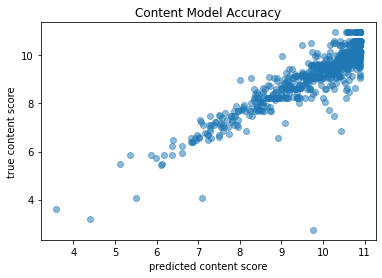

In [45]:
# from matplotlib import pyplot as plt
# con_preds.flatten()
# plt.scatter(con_preds, con_actual, alpha=0.5)
# plt.ylabel('true content score')
# plt.xlabel('predicted content score')
# plt.title('Content Model Accuracy')

#### Train the paraphrase grader

In [ ]:
# trainer = Trainer(
#     model_init=model_init,
# )

# training_args = TrainingArguments(
#     output_dir = f'./results/paraphrase_checkpoints',
#     optim = 'adamw_torch',
#     num_train_epochs = num_epochs,
#     per_device_train_batch_size = batch_size,
#     per_device_eval_batch_size = batch_size,
#     weight_decay = 0.01,
#     learning_rate = learning_rate,
#     logging_dir = f'./logs/paraphrase',
#     save_total_limit = 10,
#     load_best_model_at_end = True,
#     metric_for_best_model = 'mse',
#     evaluation_strategy = "epoch",
#     save_strategy = "epoch",
#     greater_is_better = False,
#     seed=seed,
#     log_level = 'error', # took me ages to find these options
#     disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
# ) 

#     # Call the Trainer
# paraphrase_trainer = Trainer(
#     model_init = model_init,
#     args = training_args,
#     data_collator=data_collator,
#     train_dataset = paraphrase_ds_t['train'],
#     eval_dataset = paraphrase_ds_t['valid'],
#     compute_metrics = compute_metrics_for_regression,
#     callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
# )

# # Train the model
# paraphrase_trainer.train()

In [42]:
# para_preds, para_labs, para_metrics = paraphrase_trainer.predict(paraphrase_ds_t['test'])
# paraphrase_actual = paraphrase_ds_t['test']['labels']
# scipy.stats.pearsonr(paraphrase_actual, para_preds)

(array([0.8060471019427571], dtype=object), 9.23721527462376e-207)

Text(0.5, 1.0, 'Paraphrase Model Accuracy')

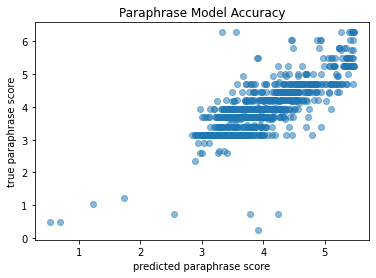

In [48]:
# from matplotlib import pyplot as plt
# para_preds.flatten()
# plt.scatter(para_preds, paraphrase_actual, alpha=0.5)
# plt.ylabel('true paraphrase score')
# plt.xlabel('predicted paraphrase score')
# plt.title('Paraphrase Model Accuracy')

## Push to the Hub

In [64]:
# content_trainer.save_model(SUMM_FOLDER / 'content_model')

In [65]:
# paraphrase_trainer.save_model(SUMM_FOLDER / 'paraphrase_model')


In [80]:
# tokenizer.save_pretrained(SUMM_FOLDER / 'tokenizer.json')

('/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/tokenizer.json/tokenizer_config.json',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/tokenizer.json/special_tokens_map.json',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/tokenizer.json/vocab.json',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/tokenizer.json/merges.txt',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/tokenizer.json/added_tokens.json')

In [70]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
# paraphrase_trainer.push_to_hub('SummaryScoreContent')

In [ ]:
# paraphrase_ds_t['test']

# def predictScore(text):
#     input_ids = tokenizer(text)
#     preds, labs, metrics = content_trainer.predict(input_ids)

# predictScore('This is a story about a young man who encountered a terrible demon')

In [62]:
# tokenizer('This is a story about a young man who encountered a terrible demon')
# paraphrase_ds_t['test']

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 900
})